In [1]:
#!/usr/bin/env python3
# ===========================================================================
#
#  GRAMMATICAL EVOLUTION: INITIALIZATION METHODS COMPARISON (v3 — CORRECTED)
#  3 Methods: Random, Sensible (RHH), PI Grow
#  4 Benchmarks: Keijzer-6, Nguyen-7, Pagie-1, Diabetes (Binary Classification)

#  Reference: BDS Group GRAPE (de Lima et al., 2022, Signals 3(3))
#  Ryan, C. & Azad, R.M.A. (2003) "Sensible Initialisation in GE"
# ===========================================================================

import sys, os, importlib.util, numpy as np, random, copy, tempfile
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.stats import mannwhitneyu, kruskal
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings, time, json
from datetime import datetime
warnings.filterwarnings('ignore')

# ── Force-load LOCAL grape.py ─────────────────
_DIR = os.getcwd()
_LOCAL = os.path.join(_DIR, 'grape.py')
if os.path.isfile(_LOCAL):
    spec = importlib.util.spec_from_file_location("grape", _LOCAL)
    grape = importlib.util.module_from_spec(spec)
    sys.modules['grape'] = grape
    spec.loader.exec_module(grape)
    print(f"[OK] Loaded grape.py from {_LOCAL}")
else:
    raise FileNotFoundError(f"grape.py not found in {_DIR}\nRun notebook inside GRAPE folder.")

if not hasattr(grape, 'PI_Grow'):
    raise AttributeError("PI_Grow not found in grape.py!")
print("[OK] PI_Grow available")

if _DIR not in sys.path:
    sys.path.insert(0, _DIR)
try:
    from functions import pdiv, plog, psqrt
    print("[OK] functions.py loaded")
except ImportError:
    def pdiv(a, b):
        with np.errstate(divide='ignore', invalid='ignore'):
            return np.where(np.abs(b) < 1e-12, np.ones_like(a, dtype=float), a / b)
    def plog(a): return np.log(1.0 + np.abs(a))
    def psqrt(a): return np.sqrt(np.abs(a))
    print("[WARN] functions.py not found — using protected fallbacks")

# ── Sigmoid for classification ───────────────────────────────────────
def sigmoid(a):
    a = np.clip(np.asarray(a, dtype=float), -500, 500)
    return 1.0 / (1.0 + np.exp(-a))

# ── DEAP setup ───────────────────────────────────────────────────────
from deap import creator, base, tools
if "FitnessMin" in dir(creator): del creator.FitnessMin
if "Individual" in dir(creator): del creator.Individual
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)
print("[OK] DEAP ready")


[OK] Loaded grape.py from c:\Users\awwal\OneDrive\Desktop\EXPERIMENT_PI_GROW\grape.py
[OK] PI_Grow available
[WARN] functions.py not found — using protected fallbacks
[OK] DEAP ready


In [2]:
# ══════════════════════════════════════════════════════════════════════
# GRAMMAR — Standard GRAPE symbolic regression grammar

In [3]:
# ══════════════════════════════════════════════════════════════════════
# Following the function set used in the GRAPE paper and standard GP/GE
# benchmarks: {+, -, *, pdiv, sin, tanh, plog, psqrt}
# NO pexp — it trivially solves Keijzer-6 and creates numerical instability.
# Ephemeral constants via <c><c>.<c><c> (range 00.00–99.99)

In [4]:
# ══════════════════════════════════════════════════════════════════════
_GRAMMAR_DIR = tempfile.mkdtemp(prefix='grape_bnf_')

def make_grammar(n_features):
    """Build BNF grammar following GRAPE standard function set."""
    vars_list = ' | '.join([f'x[{i}]' for i in range(n_features)])
    bnf = (
        "<e> ::= <e>+<e> | <e>-<e> | <e>*<e> | pdiv(<e>,<e>)"
        " | psqrt(<e>) | np.sin(<e>) | np.tanh(<e>) | plog(<e>)"
        f" | {vars_list} | <c><c>.<c><c>\n"
        "<c> ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9\n"
    )
    fname = os.path.join(_GRAMMAR_DIR, f'grammar_{n_features}feat.bnf')
    with open(fname, 'w') as f: f.write(bnf)
    g = grape.Grammar(fname)
    print(f"    Grammar ({n_features} features): {len(g.non_terminals)} NTs, "
          f"{sum(g.n_rules)} productions, "
          f"terminals include {n_features} variables + constants")
    return g


In [ ]:
# ══════════════════════════════════════════════════════════════════════
# PARAMETERS

In [5]:
# ══════════════════════════════════════════════════════════════════════
SEED = 42

# ── Population & generations ──
POP_SIZE    = 60       # Standard for GE (BDS group practice)
MAX_GENS    = 100       # Sufficient with pop=500 and elitism
ELITE_SIZE  = 1         # Preserve best individual across generations
N_RUNS      = 30        # Standard for statistical analysis

# ── Genetic operators ──
P_CX        = 0.9       # Crossover probability (standard)
P_MUT       = 0.05      # Per-codon mutation rate (higher = more exploration)
TOURN       = 3         # Tournament size (appropriate for pop=500)

# ── Initialisation ──
MIN_INIT_GL   = 30      # Random init: min genome length
MAX_INIT_GL   = 250     # Random init: max genome length (wide range)
MIN_INIT_DEPTH = 2      # Sensible/PI Grow: minimum initial tree depth
MAX_INIT_DEPTH = 6      # Sensible/PI Grow: maximum initial tree depth

# ── Mapping & representation ──
MAX_TREE_DEPTH = 17     # Maximum derivation tree depth during evolution
CODON_SIZE     = 255    # Maximum codon value
MAX_GENOME_LENGTH = None

# ╔═══════════════════════════════════════════════════════════════════╗
# ║  CRITICAL: CODON_CONSUMPTION must be 'lazy' for GRAPE           ║
# ║                                                                   ║
# ║  'lazy'  = only consume a codon when a non-terminal has >1 rule  ║
# ║  'eager' = consume a codon at every non-terminal expansion       ║
# ║                                                                   ║
# ║  Sensible init & PI Grow build phenotype-first genomes that      ║
# ║  are ONLY correct under the lazy mapper. Using 'eager' causes    ║
# ║  the tail codons to be consumed during mapping, potentially      ║
# ║  making individuals invalid. This was the root cause of          ║
# ║  Sensible/PI Grow showing <100% validity.                        ║
# ╚═══════════════════════════════════════════════════════════════════╝
CODON_CONSUMPTION = 'lazy'
GENOME_REPRESENTATION = 'list'

METHODS = ['Random', 'Sensible', 'PI Grow']
COLORS  = {'Random': '#E74C3C', 'Sensible': '#3498DB', 'PI Grow': '#2ECC71'}

print("=" * 72)
print("  GRAMMATICAL EVOLUTION — INITIALIZATION METHODS COMPARISON (v3)")
print("=" * 72)
print(f"  Population: {POP_SIZE}  |  Generations: {MAX_GENS}  |  Runs: {N_RUNS}")
print(f"  Cx: {P_CX}  |  Mut: {P_MUT}/codon  |  Tournament: {TOURN}  |  Elite: {ELITE_SIZE}")
print(f"  Mapper: {CODON_CONSUMPTION}  |  Max Depth: {MAX_TREE_DEPTH}")
print(f"  Init Depth: [{MIN_INIT_DEPTH}, {MAX_INIT_DEPTH}]  |  Init GL: [{MIN_INIT_GL}, {MAX_INIT_GL}]")
print(f"  Methods: {', '.join(METHODS)}")
print("=" * 72)


  GRAMMATICAL EVOLUTION — INITIALIZATION METHODS COMPARISON (v3)
  Population: 60  |  Generations: 100  |  Runs: 30
  Cx: 0.9  |  Mut: 0.05/codon  |  Tournament: 3  |  Elite: 1
  Mapper: lazy  |  Max Depth: 17
  Init Depth: [2, 6]  |  Init GL: [30, 250]
  Methods: Random, Sensible, PI Grow


In [ ]:
# ══════════════════════════════════════════════════════════════════════
# BENCHMARK PROBLEMS

In [6]:
# ══════════════════════════════════════════════════════════════════════
def load_keijzer6():
    """Keijzer-6: f(x) = Σ(1/i, i=1..x), train x∈[1,50], test x∈[1,120]"""
    def kf(x): return np.array([sum(1.0/i for i in range(1, int(xi)+1)) for xi in x])
    xr = np.linspace(1, 50, 50)
    xe = np.linspace(1, 120, 120)
    return np.array([xr]), kf(xr), np.array([xe]), kf(xe)

def load_nguyen7():
    """Nguyen-7: f(x) = ln(x+1) + ln(x²+1), train x∈[0,2], test x∈[0,2]"""
    xr = np.linspace(0, 2, 20)
    xe = np.linspace(0, 2, 100)
    f = lambda x: np.log(x + 1) + np.log(x**2 + 1)
    return np.array([xr]), f(xr), np.array([xe]), f(xe)

def load_pagie1():
    """Pagie-1: f(x,y) = 1/(1+x⁻⁴) + 1/(1+y⁻⁴), 2D grid"""
    v = np.linspace(-5, 5, 26)
    X0, X1 = np.meshgrid(v, v)
    x0, x1 = X0.ravel(), X1.ravel()
    with np.errstate(divide='ignore', invalid='ignore'):
        y = 1.0/(1.0 + np.power(np.abs(x0) + 1e-10, -4)) + \
            1.0/(1.0 + np.power(np.abs(x1) + 1e-10, -4))
    y = np.nan_to_num(y, nan=0.0, posinf=2.0, neginf=0.0)
    rng = np.random.RandomState(SEED)
    x0t = rng.uniform(-5, 5, 10000)
    x1t = rng.uniform(-5, 5, 10000)
    with np.errstate(divide='ignore', invalid='ignore'):
        yt = 1.0/(1.0 + np.power(np.abs(x0t) + 1e-10, -4)) + \
             1.0/(1.0 + np.power(np.abs(x1t) + 1e-10, -4))
    yt = np.nan_to_num(yt, nan=0.0, posinf=2.0, neginf=0.0)
    return np.array([x0, x1]), y, np.array([x0t, x1t]), yt

def load_diabetes_data():
    """Diabetes: binary classification (median split), stratified 70/30."""
    d = load_diabetes()
    X, y_cont = d.data, d.target
    median_val = np.median(y_cont)
    y = (y_cont >= median_val).astype(float)
    print(f"    Diabetes: median={median_val:.1f}, "
          f"class0={int(np.sum(y==0))}, class1={int(np.sum(y==1))}")
    Xr, Xe, yr, ye = train_test_split(
        X, y, test_size=0.3, random_state=SEED, stratify=y)
    return Xr.T, yr, Xe.T, ye

PROBLEMS = OrderedDict([
    ('Keijzer-6',  {'loader': load_keijzer6,      'n_features': 1,
                    'desc': 'Harmonic (1D)',       'task': 'regression'}),
    ('Nguyen-7',   {'loader': load_nguyen7,       'n_features': 1,
                    'desc': 'ln(x+1)+ln(x²+1)',   'task': 'regression'}),
    ('Pagie-1',    {'loader': load_pagie1,        'n_features': 2,
                    'desc': '2D surface',          'task': 'regression'}),
    ('Diabetes',   {'loader': load_diabetes_data, 'n_features': 10,
                    'desc': 'Binary (10D)',        'task': 'classification'}),
])


In [ ]:
# ══════════════════════════════════════════════════════════════════════
# FITNESS FUNCTIONS

In [7]:
# ══════════════════════════════════════════════════════════════════════
_EG = {
    'np': np, 'pdiv': pdiv, 'plog': plog, 'psqrt': psqrt,
    'sigmoid': sigmoid, '__builtins__': {}
}

# Cap extreme MSE to prevent plot distortion
FITNESS_CAP = 1e8

def fitness_eval_regression(ind, pts):
    """MSE fitness for regression (minimise)."""
    x, y = pts[0], pts[1]
    if ind.invalid: return (np.nan,)
    try:
        pred = eval(ind.phenotype, _EG, {'x': x})
    except:
        return (np.nan,)
    try:
        pred = np.asarray(pred, dtype=float)
        if pred.ndim == 0:
            pred = np.full_like(y, float(pred))
        if not np.all(np.isfinite(pred)):
            return (np.nan,)
        f = float(np.mean(np.square(y - pred)))
    except:
        return (np.nan,)
    if not np.isfinite(f): return (np.nan,)
    return (min(f, FITNESS_CAP),)

def fitness_eval_classification(ind, pts):
    """Binary cross-entropy (log-loss) for classification (minimise)."""
    x, y = pts[0], pts[1]
    if ind.invalid: return (np.nan,)
    try:
        raw = eval(ind.phenotype, _EG, {'x': x})
    except:
        return (np.nan,)
    try:
        raw = np.asarray(raw, dtype=float)
        if raw.ndim == 0:
            raw = np.full_like(y, float(raw))
        if not np.all(np.isfinite(raw)):
            return (np.nan,)
        prob = sigmoid(raw)
        eps = 1e-15
        prob = np.clip(prob, eps, 1.0 - eps)
        bce = -np.mean(y * np.log(prob) + (1.0 - y) * np.log(1.0 - prob))
        f = float(bce)
    except:
        return (np.nan,)
    if not np.isfinite(f): return (np.nan,)
    return (f,)

def classification_accuracy(ind, pts):
    """Classification accuracy (for reporting only)."""
    x, y = pts[0], pts[1]
    if ind.invalid: return np.nan
    try:
        raw = eval(ind.phenotype, _EG, {'x': x})
        raw = np.asarray(raw, dtype=float)
        if raw.ndim == 0:
            raw = np.full_like(y, float(raw))
        prob = sigmoid(raw)
        preds = (prob >= 0.5).astype(float)
        return float(accuracy_score(y, preds))
    except:
        return np.nan

def get_fitness_func(task):
    return fitness_eval_classification if task == 'classification' else fitness_eval_regression

def gfv(ind):
    """Get fitness value, returning nan if invalid."""
    if not ind.fitness.valid: return np.nan
    v = ind.fitness.values[0]
    return np.nan if (v is None or np.isnan(v)) else v


In [ ]:
# ══════════════════════════════════════════════════════════════════════
# INITIALISATION — using GRAPE's built-in methods

In [8]:
# ══════════════════════════════════════════════════════════════════════
def create_pop(method, grammar):
    """Create initial population using GRAPE's initialisation methods.
    
    - Random: random_initialisation (genome-first, may produce invalids)
    - Sensible: sensible_initialisation (phenotype-first, RHH, 100% valid)
    - PI Grow: PI_Grow (phenotype-first, position-independent, 100% valid)
    """
    if method == 'Random':
        return grape.random_initialisation(
            creator.Individual, POP_SIZE, grammar,
            MIN_INIT_GL, MAX_INIT_GL, MAX_TREE_DEPTH,
            CODON_SIZE, CODON_CONSUMPTION, GENOME_REPRESENTATION)
    elif method == 'Sensible':
        return grape.sensible_initialisation(
            creator.Individual, POP_SIZE, grammar,
            MIN_INIT_DEPTH, MAX_INIT_DEPTH,
            CODON_SIZE, CODON_CONSUMPTION, GENOME_REPRESENTATION)
    elif method == 'PI Grow':
        return grape.PI_Grow(
            creator.Individual, POP_SIZE, grammar,
            MIN_INIT_DEPTH, MAX_INIT_DEPTH,
            CODON_SIZE, CODON_CONSUMPTION, GENOME_REPRESENTATION)


In [ ]:
# ══════════════════════════════════════════════════════════════════════
# SINGLE EVOLUTIONARY RUN

In [9]:
# ══════════════════════════════════════════════════════════════════════
def run_ge(init_method, grammar, Xr, Yr, Xe, Ye, seed, task='regression'):
    random.seed(seed)
    np.random.seed(seed)
    fitness_func = get_fitness_func(task)
    ptr, pte = [Xr, Yr], [Xe, Ye]

    # ── Initialise population ────────────────────────────────────────
    pop = create_pop(init_method, grammar)
    for ind in pop:
        ind.fitness.values = fitness_func(ind, ptr)

    valid = [i for i in pop if not i.invalid and not np.isnan(gfv(i))]
    n_valid = len(valid)

    init_stats = {
        'validity':     n_valid / POP_SIZE,
        'best_fitness': float(min(gfv(i) for i in valid)) if valid else np.nan,
        'mean_fitness': float(np.nanmean([gfv(i) for i in valid])) if valid else np.nan,
        'mean_depth':   float(np.mean([i.depth for i in valid])) if valid else 0,
        'mean_nodes':   float(np.mean([i.nodes for i in valid])) if valid else 0,
        'mean_gl':      float(np.mean([len(i.genome) for i in valid])) if valid else 0,
        'unique_pheno': len(set(i.phenotype for i in valid if i.phenotype)),
        'pheno_div':    (len(set(i.phenotype for i in valid if i.phenotype))
                         / max(n_valid, 1)) if valid else 0,
    }
    if task == 'classification' and valid:
        accs = [classification_accuracy(i, ptr) for i in valid]
        accs = [a for a in accs if not np.isnan(a)]
        init_stats['best_accuracy'] = max(accs) if accs else np.nan
        init_stats['mean_accuracy'] = float(np.mean(accs)) if accs else np.nan

    # ── Tracking arrays ──────────────────────────────────────────────
    # NOTE ON DIVERSITY MEASURES:
    #   'pheno_div'    = ratio of unique phenotype STRINGS in the population
    #                    (syntactic phenotypic diversity — counts distinct expressions)
    #   'semantic_div' = ratio of unique OUTPUT VECTORS (rounded to 6 d.p.)
    #                    (behavioural diversity — counts distinct functions)
    #   The original 'struct_div' used i.structure (derivation tree), which
    #   is closer to genotypic diversity. It overestimates true phenotypic
    #   diversity because many different derivation trees can produce the
    #   same phenotype, and bloat creates novel structures without new
    #   behaviour. This explains the upward trend — it's measuring
    #   genotypic novelty, not functional diversity.
    hist = {
        'min': [], 'avg': [], 'invalid': [], 'fitness_test': [],
        'avg_depth': [], 'avg_nodes': [],
        'pheno_div': [],     # unique phenotype strings / pop size
        'semantic_div': [],  # unique output vectors / pop size
    }
    if task == 'classification':
        hist['train_acc'] = []
        hist['test_acc'] = []

    hof = tools.HallOfFame(3)

    # ── Generational loop ────────────────────────────────────────────
    for gen in range(MAX_GENS + 1):
        vp = [i for i in pop if not i.invalid and not np.isnan(gfv(i))]
        fits = [gfv(i) for i in vp]
        if vp:
            hof.update(vp)

        # Test fitness of best-ever individual
        if len(hof) > 0 and not hof[0].invalid:
            tf = fitness_func(hof[0], pte)[0]
        else:
            tf = np.nan

        hist['min'].append(float(min(fits)) if fits else np.nan)
        hist['avg'].append(float(np.mean(fits)) if fits else np.nan)
        hist['invalid'].append(POP_SIZE - len(vp))
        hist['fitness_test'].append(float(tf) if np.isfinite(tf) else np.nan)
        depths = [i.depth for i in vp]
        nodes  = [i.nodes for i in vp]
        hist['avg_depth'].append(float(np.mean(depths)) if vp else 0)
        hist['avg_nodes'].append(float(np.mean(nodes)) if vp else 0)
        
        # ── Phenotypic diversity (unique expression strings) ─────────
        phenos = set()
        for i in vp:
            if i.phenotype:
                phenos.add(i.phenotype)
        hist['pheno_div'].append(len(phenos) / max(len(vp), 1) if vp else 0)
        
        # ── Semantic diversity (unique output vectors) ───────────────
        # Round outputs to 6 d.p. to group near-identical behaviours
        semantics = set()
        for i in vp:
            if i.phenotype and not i.invalid:
                try:
                    out = eval(i.phenotype, _EG, {'x': Xr})
                    out = np.asarray(out, dtype=float)
                    if out.ndim == 0:
                        out = np.full(Yr.shape, float(out))
                    if np.all(np.isfinite(out)):
                        semantics.add(tuple(np.round(out, 6)))
                except:
                    pass
        hist['semantic_div'].append(len(semantics) / max(len(vp), 1) if vp else 0)

        if task == 'classification':
            tr_acc = classification_accuracy(hof[0], ptr) if len(hof) > 0 and not hof[0].invalid else np.nan
            te_acc = classification_accuracy(hof[0], pte) if len(hof) > 0 and not hof[0].invalid else np.nan
            hist['train_acc'].append(float(tr_acc) if np.isfinite(tr_acc) else np.nan)
            hist['test_acc'].append(float(te_acc) if np.isfinite(te_acc) else np.nan)

        if gen == MAX_GENS:
            break

        # ── Elitism ──────────────────────────────────────────────────
        elite = []
        if vp:
            sorted_vp = sorted(vp, key=lambda i: gfv(i))
            elite = [copy.deepcopy(sorted_vp[j])
                     for j in range(min(ELITE_SIZE, len(sorted_vp)))]

        # ── Selection ────────────────────────────────────────────────
        n_offspring = POP_SIZE - ELITE_SIZE
        if vp:
            sel = tools.selTournament(vp, n_offspring, tournsize=TOURN)
        else:
            sel = [copy.deepcopy(i) for i in pop[:n_offspring]]
        off = [copy.deepcopy(i) for i in sel]

        # ── Crossover ────────────────────────────────────────────────
        for i in range(1, len(off), 2):
            if random.random() < P_CX:
                off[i-1], off[i] = grape.crossover_onepoint(
                    off[i-1], off[i], grammar, MAX_TREE_DEPTH,
                    CODON_CONSUMPTION, GENOME_REPRESENTATION, MAX_GENOME_LENGTH)

        # ── Mutation ─────────────────────────────────────────────────
        for i in range(len(off)):
            off[i], = grape.mutation_int_flip_per_codon(
                off[i], P_MUT, CODON_SIZE, grammar, MAX_TREE_DEPTH,
                CODON_CONSUMPTION, MAX_GENOME_LENGTH)

        # ── Evaluate new offspring ───────────────────────────────────
        for ind in off:
            if not ind.fitness.valid:
                ind.fitness.values = fitness_func(ind, ptr)

        # ── Next generation = offspring + elite ──────────────────────
        pop = off + elite

    # ── Collect final results ────────────────────────────────────────
    best = hof[0] if len(hof) > 0 else None
    ft = fitness_func(best, pte)[0] if best and not best.invalid else np.nan

    result = {
        'init': init_stats,
        'hist': hist,
        'train_fitness': gfv(best) if best else np.nan,
        'test_fitness':  float(ft) if np.isfinite(ft) else np.nan,
        'pheno': best.phenotype if best else None,
        'depth': best.depth if best else 0,
        'nodes': best.nodes if best else 0,
        'gl':    len(best.genome) if best else 0,
        'task':  task,
    }
    if task == 'classification' and best and not best.invalid:
        result['train_acc'] = classification_accuracy(best, ptr)
        result['test_acc']  = classification_accuracy(best, pte)
    elif task == 'classification':
        result['train_acc'] = np.nan
        result['test_acc']  = np.nan
    if task == 'regression':
        result['train_mse'] = result['train_fitness']
        result['test_mse']  = result['test_fitness']

    return result


In [ ]:
# ══════════════════════════════════════════════════════════════════════
# RUN ALL EXPERIMENTS

In [10]:
# ══════════════════════════════════════════════════════════════════════
total_runs = len(PROBLEMS) * len(METHODS) * N_RUNS
print(f"\nSTARTING: {len(PROBLEMS)} problems × {len(METHODS)} methods × {N_RUNS} runs = {total_runs} runs\n")

all_results = {}
t0_all = time.time()

for pn, pi in PROBLEMS.items():
    print(f"\n{'#'*65}\n# {pn}: {pi['desc']} ({pi['task']})\n{'#'*65}")
    grammar = make_grammar(pi['n_features'])
    pr = {}
    for mn in METHODS:
        t0 = time.time()
        runs = []
        for r in range(N_RUNS):
            if (r+1) % 10 == 0 or r == 0:
                print(f"  {mn:>10s} run {r+1:>2d}/{N_RUNS}...", flush=True)
            np.random.seed(SEED + r)
            random.seed(SEED + r)
            Xr, Yr, Xe, Ye = pi['loader']()
            runs.append(run_ge(mn, grammar, Xr, Yr, Xe, Ye, SEED + r, task=pi['task']))
        elapsed = time.time() - t0
        print(f"  {mn:>10s}: {elapsed:.0f}s total ({elapsed/N_RUNS:.1f}s/run)")
        pr[mn] = runs
    all_results[pn] = pr

total_t = time.time() - t0_all
print(f"\n{'='*72}\n COMPLETED in {total_t/60:.1f} min\n{'='*72}")



STARTING: 4 problems × 3 methods × 30 runs = 360 runs


#################################################################
# Keijzer-6: Harmonic (1D) (regression)
#################################################################
    Grammar (1 features): 2 NTs, 20 productions, terminals include 1 variables + constants
      Random run  1/30...
      Random run 10/30...
      Random run 20/30...
      Random run 30/30...
      Random: 51s total (1.7s/run)
    Sensible run  1/30...
    Sensible run 10/30...
    Sensible run 20/30...
    Sensible run 30/30...
    Sensible: 86s total (2.9s/run)
     PI Grow run  1/30...
     PI Grow run 10/30...
     PI Grow run 20/30...
     PI Grow run 30/30...
     PI Grow: 74s total (2.5s/run)

#################################################################
# Nguyen-7: ln(x+1)+ln(x²+1) (regression)
#################################################################
    Grammar (1 features): 2 NTs, 20 productions, terminals include 1 variables + constan

In [ ]:
# ══════════════════════════════════════════════════════════════════════
# VERIFY VALIDITY FIX

In [11]:
# ══════════════════════════════════════════════════════════════════════
print("\n" + "="*72)
print(" VALIDITY VERIFICATION")
print("="*72)
for pn in all_results:
    for mn in METHODS:
        vals = [r['init']['validity']*100 for r in all_results[pn][mn]]
        mean_v = np.mean(vals)
        min_v = np.min(vals)
        status = "✓" if (mn == 'Random' or min_v >= 99.9) else "✗ STILL BROKEN"
        print(f"  {pn:<12s} {mn:<10s}: mean={mean_v:6.2f}%, min={min_v:6.2f}%  {status}")



 VALIDITY VERIFICATION
  Keijzer-6    Random    : mean= 47.33%, min= 36.67%  ✓
  Keijzer-6    Sensible  : mean=100.00%, min=100.00%  ✓
  Keijzer-6    PI Grow   : mean=100.00%, min=100.00%  ✓
  Nguyen-7     Random    : mean= 47.33%, min= 36.67%  ✓
  Nguyen-7     Sensible  : mean=100.00%, min=100.00%  ✓
  Nguyen-7     PI Grow   : mean=100.00%, min=100.00%  ✓
  Pagie-1      Random    : mean= 69.39%, min= 61.67%  ✓
  Pagie-1      Sensible  : mean=100.00%, min=100.00%  ✓
  Pagie-1      PI Grow   : mean=100.00%, min=100.00%  ✓
  Diabetes     Random    : mean= 99.78%, min= 98.33%  ✓
  Diabetes     Sensible  : mean=100.00%, min=100.00%  ✓
  Diabetes     PI Grow   : mean=100.00%, min=100.00%  ✓


In [ ]:
# ══════════════════════════════════════════════════════════════════════
# STATISTICAL ANALYSIS

In [12]:
# ══════════════════════════════════════════════════════════════════════
def sig_stars(p):
    if p < 0.001: return "***"
    elif p < 0.01: return "**"
    elif p < 0.05: return "*"
    return "ns"

def vda(a, b):
    m, n = len(a), len(b)
    if m == 0 or n == 0: return 0.5
    return sum(1 if ai < bi else 0.5 if ai == bi else 0 for ai in a for bi in b) / (m * n)

def effect_label(a):
    d = abs(a - 0.5)
    if d < 0.06: return "negl"
    elif d < 0.14: return "small"
    elif d < 0.21: return "medium"
    return "large"

def safe_vals(lst):
    return [x for x in lst if x is not None and np.isfinite(x) and abs(x) < 1e10]

for pn, res in all_results.items():
    task = PROBLEMS[pn]['task']
    print(f"\n{'='*72}\n {pn} ({'Classification' if task=='classification' else 'Regression'})\n{'='*72}")

    if task == 'classification':
        metrics = [
            ("Init Validity %",      lambda r: r['init']['validity']*100),
            ("Init Unique Pheno",    lambda r: r['init']['unique_pheno']),
            ("Init Mean Depth",      lambda r: r['init']['mean_depth']),
            ("Init Pheno Div",       lambda r: r['init']['pheno_div']),
            ("Init Best Log-Loss",   lambda r: r['init']['best_fitness']),
            ("Init Mean Log-Loss",   lambda r: r['init']['mean_fitness']),
            ("Init Best Accuracy",   lambda r: r['init'].get('best_accuracy', np.nan)),
            ("Init Mean Accuracy",   lambda r: r['init'].get('mean_accuracy', np.nan)),
            ("Final Train Log-Loss", lambda r: r['train_fitness']),
            ("Final Test Log-Loss",  lambda r: r['test_fitness']),
            ("Final Train Accuracy", lambda r: r.get('train_acc', np.nan)),
            ("Final Test Accuracy",  lambda r: r.get('test_acc', np.nan)),
        ]
    else:
        metrics = [
            ("Init Validity %",    lambda r: r['init']['validity']*100),
            ("Init Unique Pheno",  lambda r: r['init']['unique_pheno']),
            ("Init Mean Depth",    lambda r: r['init']['mean_depth']),
            ("Init Pheno Div",    lambda r: r['init']['pheno_div']),
            ("Init Best MSE",      lambda r: r['init']['best_fitness']),
            ("Init Mean MSE",      lambda r: r['init']['mean_fitness']),
            ("Final Train MSE",    lambda r: r['train_fitness']),
            ("Final Test MSE",     lambda r: r['test_fitness']),
        ]

    for label, ext in metrics:
        vals = {m: safe_vals([ext(r) for r in res[m]]) for m in METHODS}
        parts = []
        for m in METHODS:
            if vals[m]:
                parts.append(f"{m}={np.mean(vals[m]):>9.4f}±{np.std(vals[m]):<7.4f}")
            else:
                parts.append(f"{m}={'N/A':>9}")
        print(f"  {label:<24}: {'  '.join(parts)}")

        # Kruskal-Wallis
        all_groups = [vals[m] for m in METHODS if vals[m] and len(vals[m]) >= 3]
        if len(all_groups) >= 2:
            try:
                H, p_kw = kruskal(*all_groups)
                print(f"    Kruskal-Wallis: H={H:.3f}, p={p_kw:.6f} ({sig_stars(p_kw)})")
            except: pass

        # Pairwise comparisons
        pw = []
        for a, b in [('Random','Sensible'),('Random','PI Grow'),('Sensible','PI Grow')]:
            if vals[a] and vals[b] and len(vals[a]) >= 3 and len(vals[b]) >= 3:
                _, p = mannwhitneyu(vals[a], vals[b], alternative='two-sided')
                ae = vda(vals[a], vals[b])
                pw.append(f"{a[:3]}v{b[:3]}: p={p:.4f}({sig_stars(p)}) A={ae:.3f}({effect_label(ae)})")
        if pw:
            print(f"    {'  |  '.join(pw)}")

    print(f"\n  Best solutions (by train fitness):")
    for m in METHODS:
        v = [r for r in res[m] if np.isfinite(r.get('train_fitness', np.nan))]
        if v:
            b = min(v, key=lambda r: r['train_fitness'])
            if task == 'classification':
                print(f"    {m}: LL={b['train_fitness']:.6f} TestLL={b['test_fitness']:.6f} "
                      f"TrAcc={b.get('train_acc',np.nan):.4f} TeAcc={b.get('test_acc',np.nan):.4f} "
                      f"D={b['depth']} N={b['nodes']}")
            else:
                print(f"    {m}: TrainMSE={b['train_fitness']:.6f} TestMSE={b['test_fitness']:.6f} "
                      f"D={b['depth']} N={b['nodes']}")
            pheno = (b['pheno'] or 'N/A')[:120]
            print(f"      expr: {pheno}")

# ── Summary tables ───────────────────────────────────────────────────
print("\n" + "=" * 80 + "\n SUMMARY TABLES\n" + "=" * 80)
pnames = list(all_results.keys())

for tl, kf, higher_better in [
    ("INITIAL VALIDITY (%)",            lambda r: r['init']['validity']*100, True),
    ("TRAIN FITNESS (MSE/LogLoss)",     lambda r: r['train_fitness'],       False),
    ("TEST FITNESS (MSE/LogLoss)",      lambda r: r['test_fitness'],        False),
]:
    print(f"\n{'-'*80}\n {tl}\n{'-'*80}")
    h = f"{'Problem':<13}"
    for m in METHODS: h += f"  {m:>16}"
    h += f"  {'Best':>10}"
    print(h); print("-"*80)
    for p in pnames:
        row = f"{p:<13}"; means = {}
        for m in METHODS:
            v = safe_vals([kf(r) for r in all_results[p][m]])
            if v:
                means[m] = np.mean(v)
                row += f"  {np.mean(v):>7.4f}±{np.std(v):>6.4f}"
            else:
                means[m] = float('inf') if not higher_better else float('-inf')
                row += f"  {'N/A':>16}"
        if higher_better:
            bm = max(means, key=means.get)
        else:
            bm = min(means, key=means.get)
        row += f"  {bm:>10}"
        print(row)

# Classification accuracy summary
cls_problems = [p for p in pnames if PROBLEMS[p]['task'] == 'classification']
if cls_problems:
    for tl, kf in [("TRAIN ACCURACY", lambda r: r.get('train_acc', np.nan)),
                    ("TEST ACCURACY",  lambda r: r.get('test_acc', np.nan))]:
        print(f"\n{'-'*80}\n {tl}\n{'-'*80}")
        h = f"{'Problem':<13}"
        for m in METHODS: h += f"  {m:>16}"
        h += f"  {'Best':>10}"; print(h); print("-"*80)
        for p in cls_problems:
            row = f"{p:<13}"; means = {}
            for m in METHODS:
                v = safe_vals([kf(r) for r in all_results[p][m]])
                if v:
                    means[m] = np.mean(v)
                    row += f"  {np.mean(v):>7.4f}±{np.std(v):>6.4f}"
                else:
                    means[m] = float('-inf')
                    row += f"  {'N/A':>16}"
            bm = max(means, key=means.get)
            row += f"  {bm:>10}"; print(row)



 Keijzer-6 (Regression)
  Init Validity %         : Random=  47.3333±6.7440   Sensible= 100.0000±0.0000   PI Grow= 100.0000±0.0000 
    Kruskal-Wallis: H=84.365, p=0.000000 (***)
    RanvSen: p=0.0000(***) A=1.000(large)  |  RanvPI : p=0.0000(***) A=1.000(large)  |  SenvPI : p=1.0000(ns) A=0.500(negl)
  Init Unique Pheno       : Random=  23.1000±3.9946   Sensible=  51.6000±1.4967   PI Grow=  42.3667±1.4488 
    Kruskal-Wallis: H=79.430, p=0.000000 (***)
    RanvSen: p=0.0000(***) A=1.000(large)  |  RanvPI : p=0.0000(***) A=1.000(large)  |  SenvPI : p=0.0000(***) A=0.000(large)
  Init Mean Depth         : Random=   4.5707±0.4988   Sensible=   4.7800±0.0801   PI Grow=   3.9978±0.0071 
    Kruskal-Wallis: H=63.058, p=0.000000 (***)
    RanvSen: p=0.0007(***) A=0.756(large)  |  RanvPI : p=0.0000(***) A=0.033(large)  |  SenvPI : p=0.0000(***) A=0.000(large)
  Init Pheno Div          : Random=   0.8127±0.0701   Sensible=   0.8600±0.0249   PI Grow=   0.7061±0.0241 
    Kruskal-Wallis: H=53.3

In [ ]:
# ══════════════════════════════════════════════════════════════════════
# PUBLICATION-QUALITY PLOTS


──────────────────────────────────────────────────
 Plots: Keijzer-6 (Regression)
──────────────────────────────────────────────────


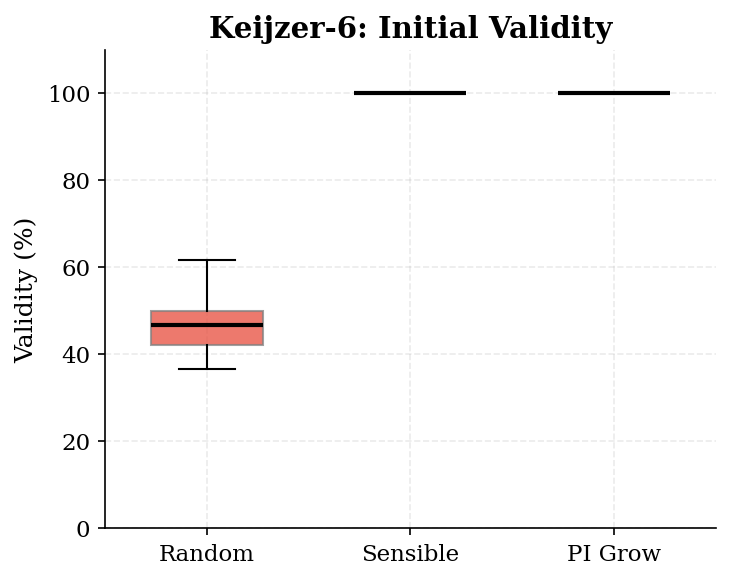

  Saved: fig1_keijzer6_validity.png


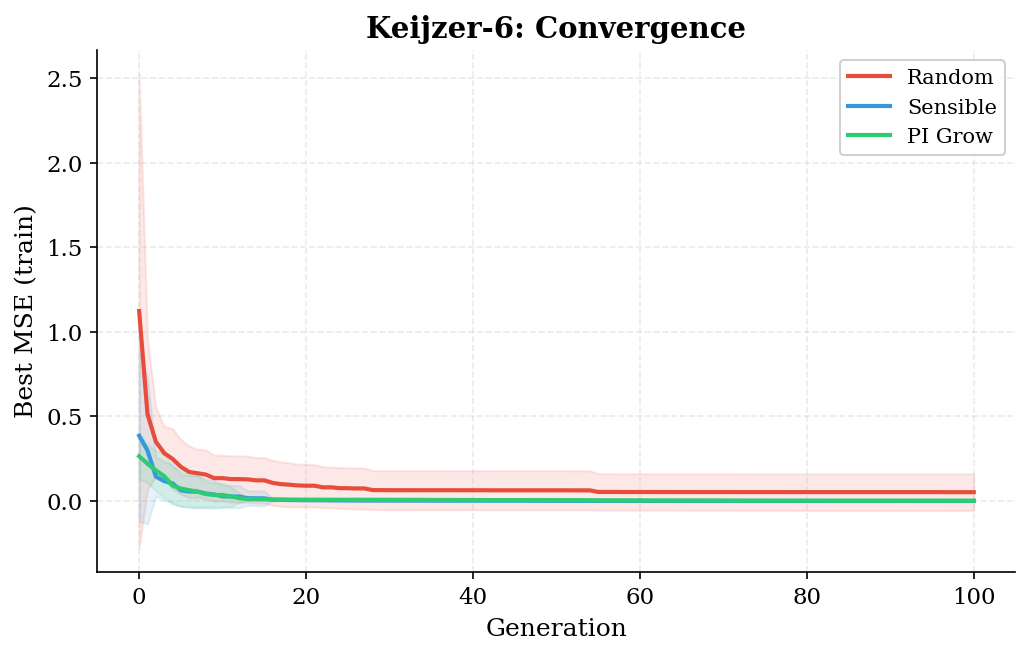

  Saved: fig2_conv_keijzer6.png


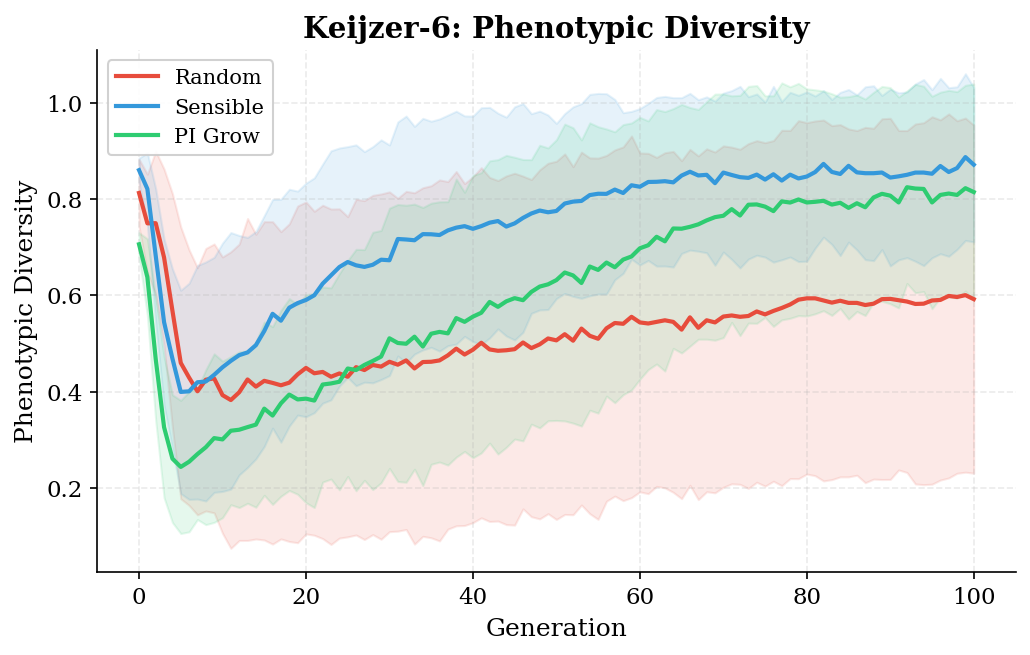

  Saved: fig3_phenodiv_keijzer6.png


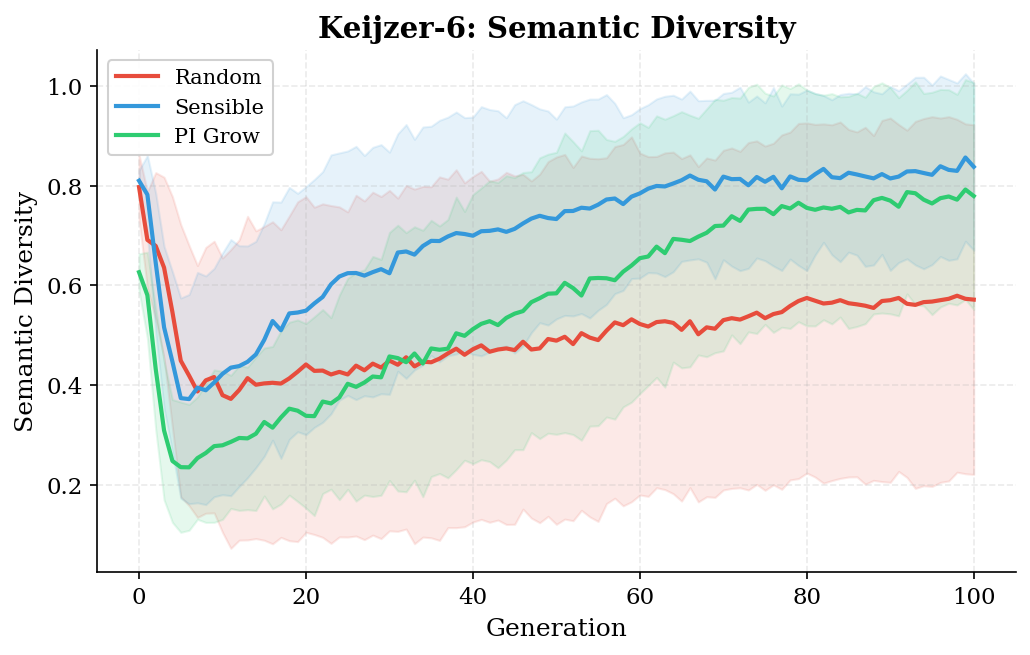

  Saved: fig3b_semdiv_keijzer6.png


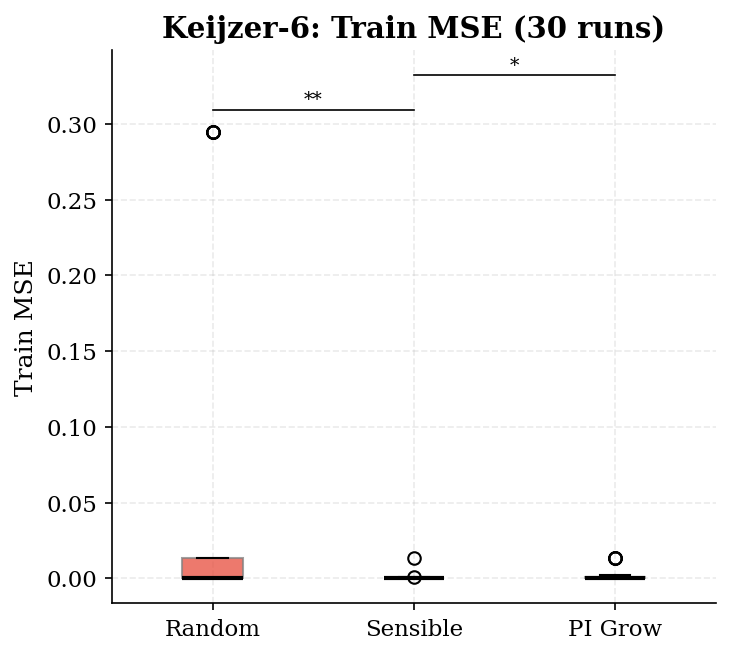

  Saved: fig4_train_keijzer6.png


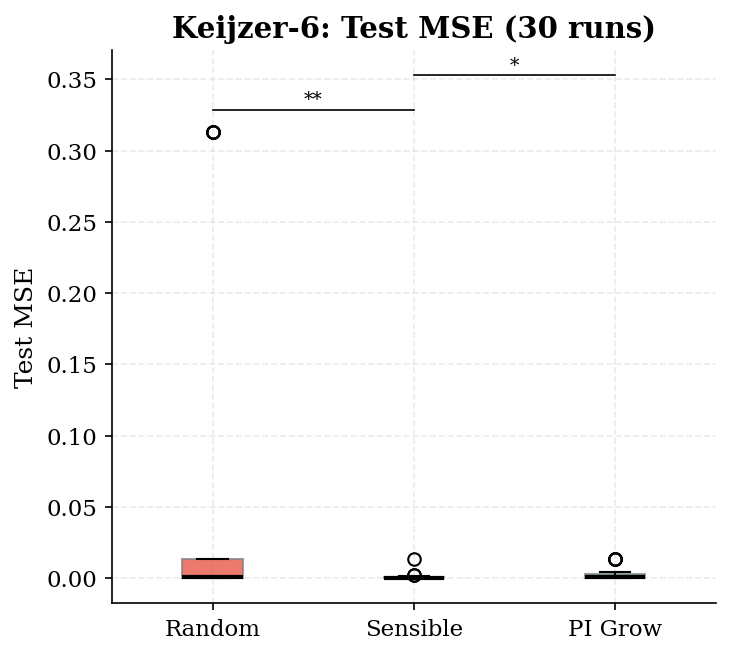

  Saved: fig5_test_keijzer6.png


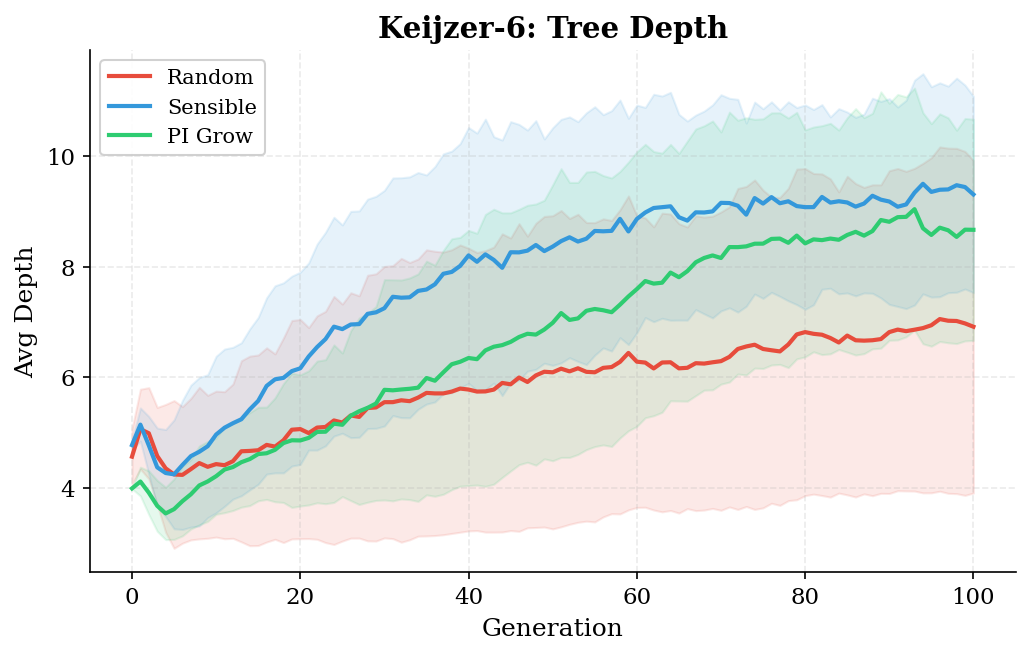

  Saved: fig6_depth_keijzer6.png


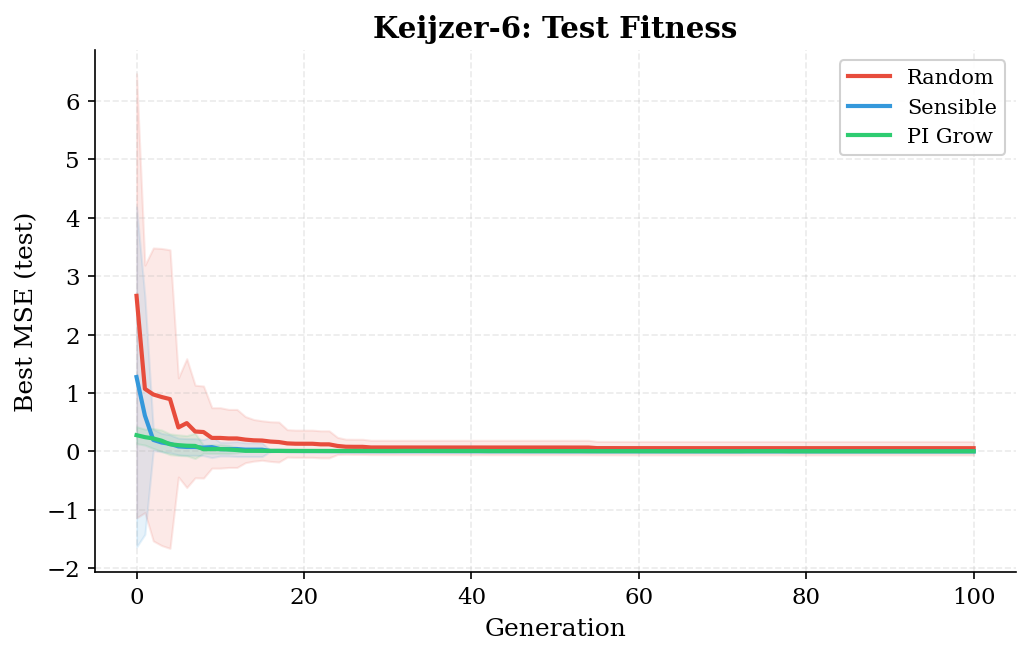

  Saved: fig7_testconv_keijzer6.png

──────────────────────────────────────────────────
 Plots: Nguyen-7 (Regression)
──────────────────────────────────────────────────


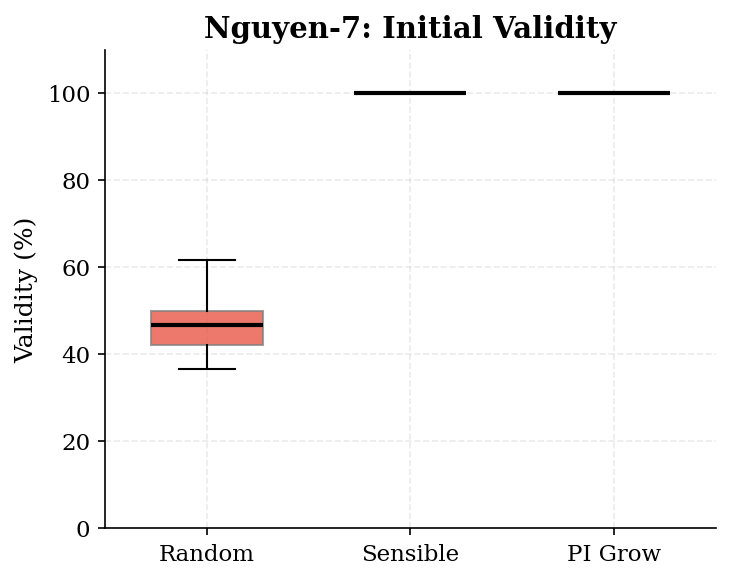

  Saved: fig1_nguyen7_validity.png


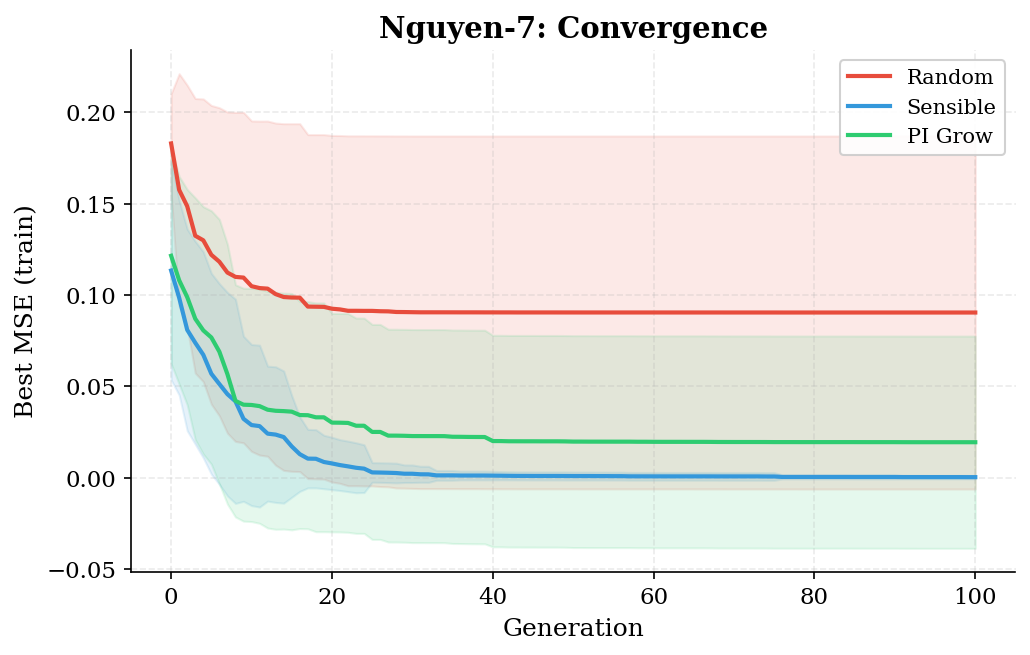

  Saved: fig2_conv_nguyen7.png


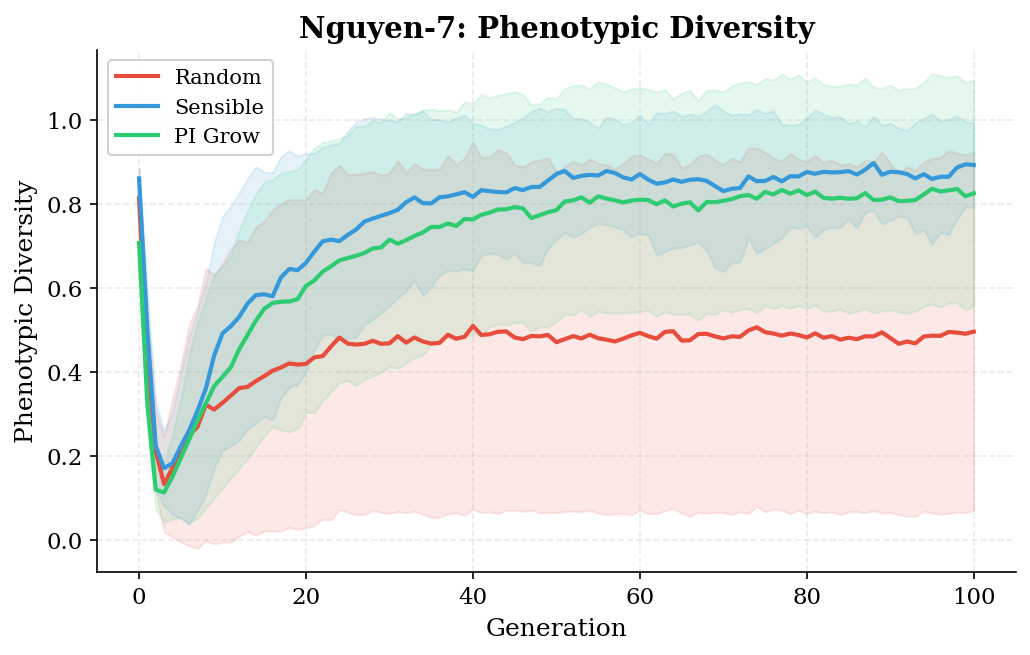

  Saved: fig3_phenodiv_nguyen7.png


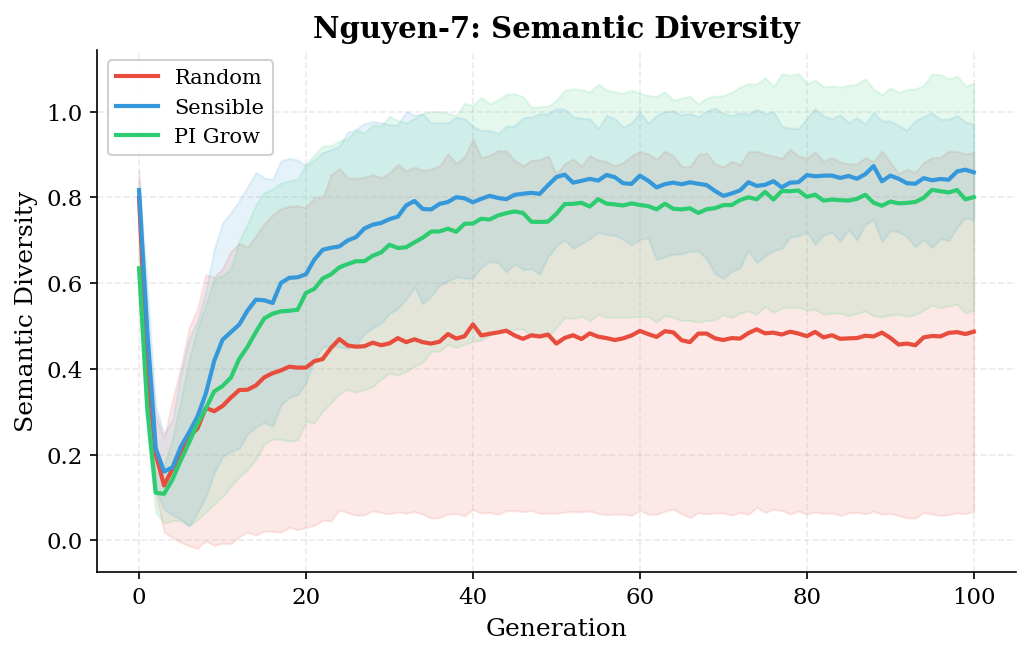

  Saved: fig3b_semdiv_nguyen7.png


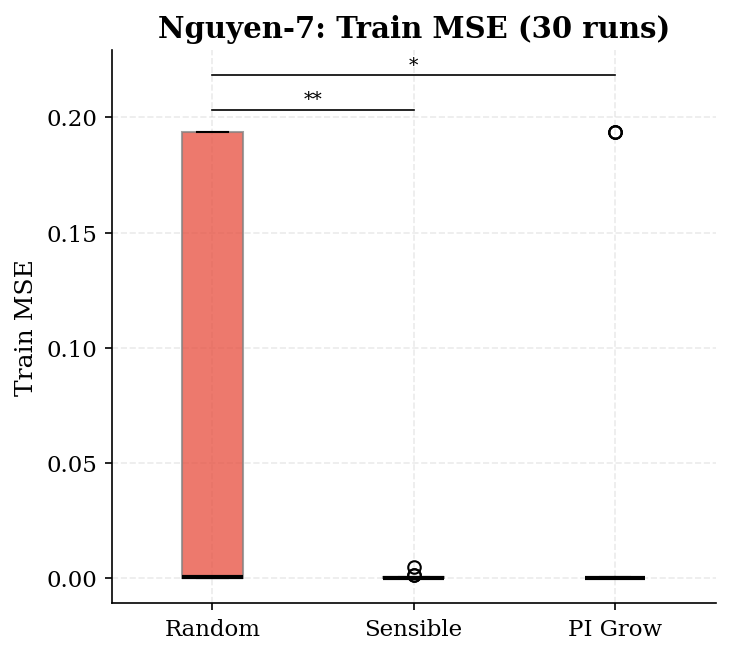

  Saved: fig4_train_nguyen7.png


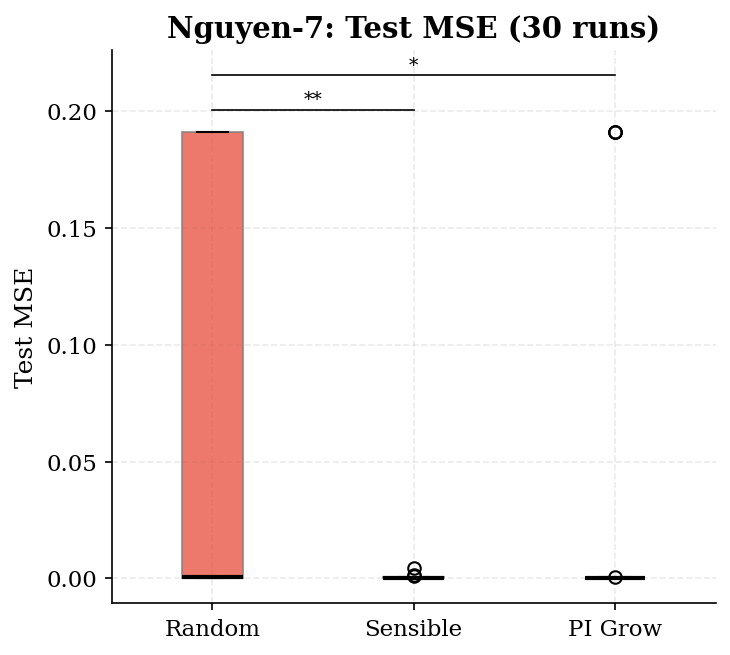

  Saved: fig5_test_nguyen7.png


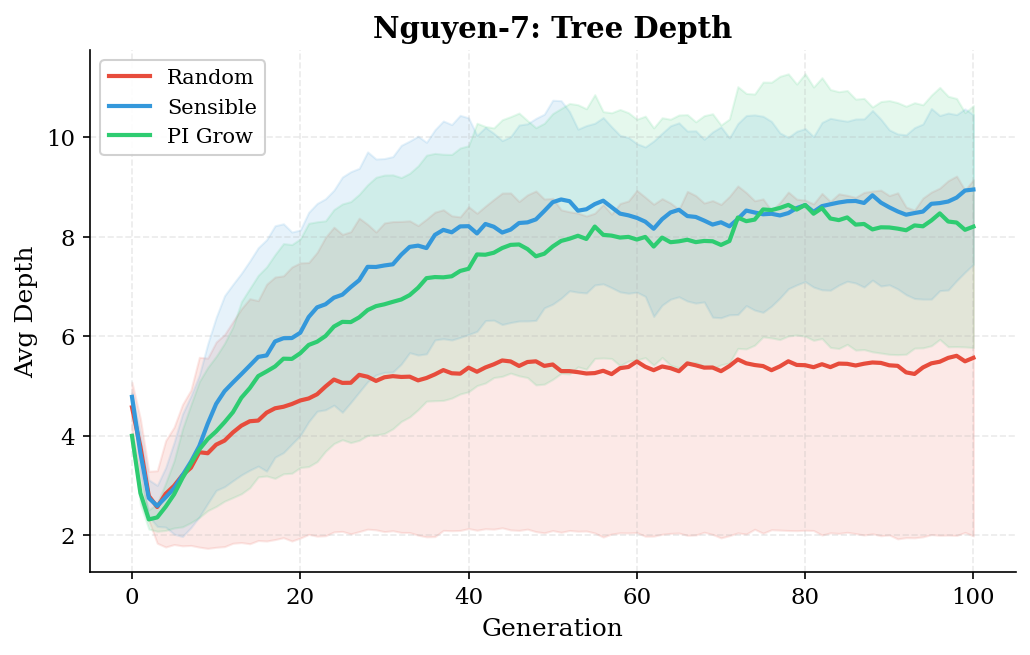

  Saved: fig6_depth_nguyen7.png


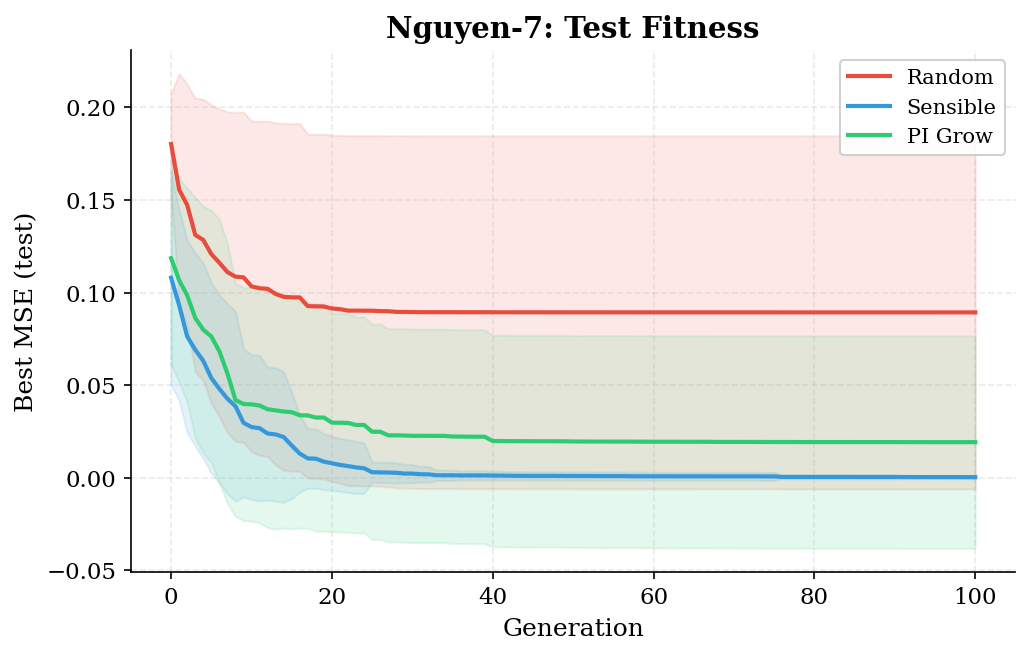

  Saved: fig7_testconv_nguyen7.png

──────────────────────────────────────────────────
 Plots: Pagie-1 (Regression)
──────────────────────────────────────────────────


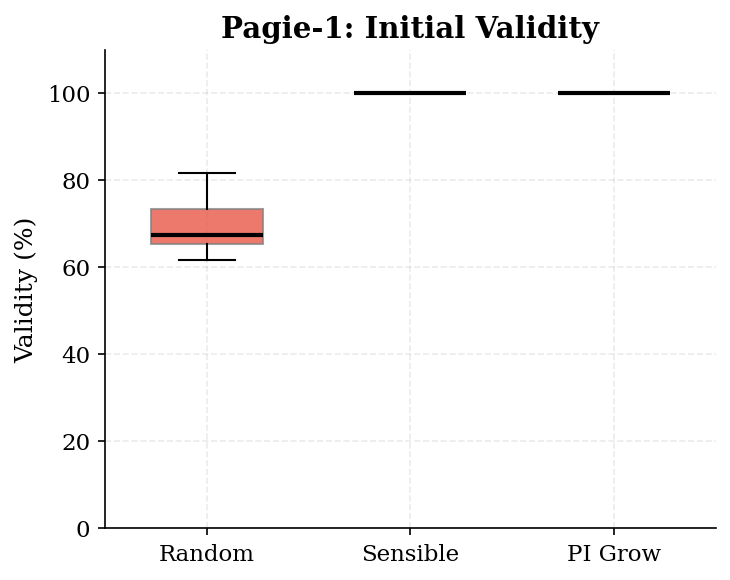

  Saved: fig1_pagie1_validity.png


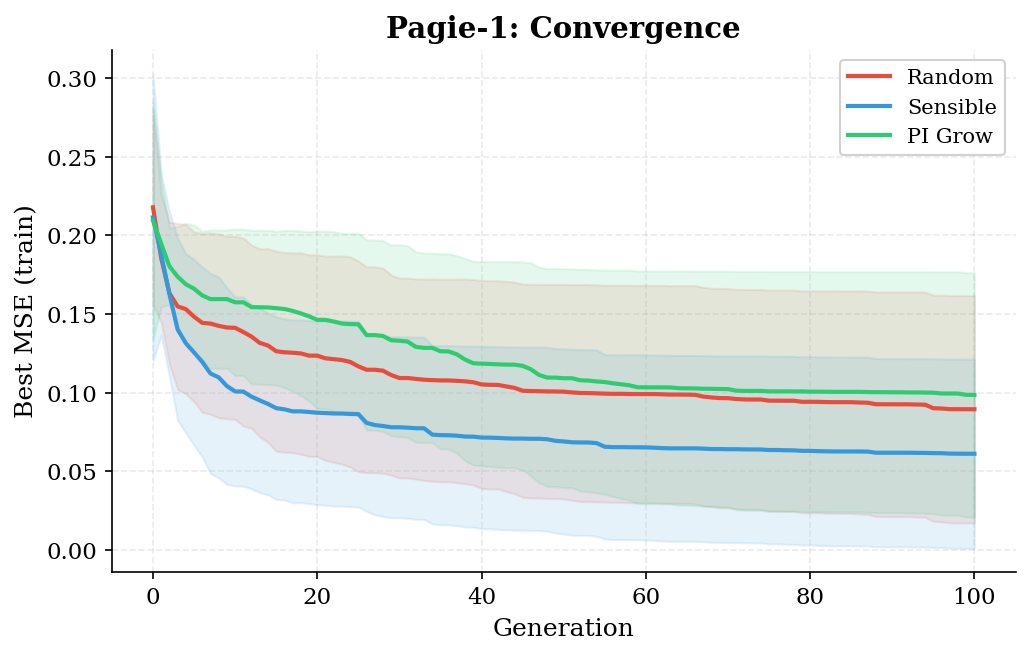

  Saved: fig2_conv_pagie1.png


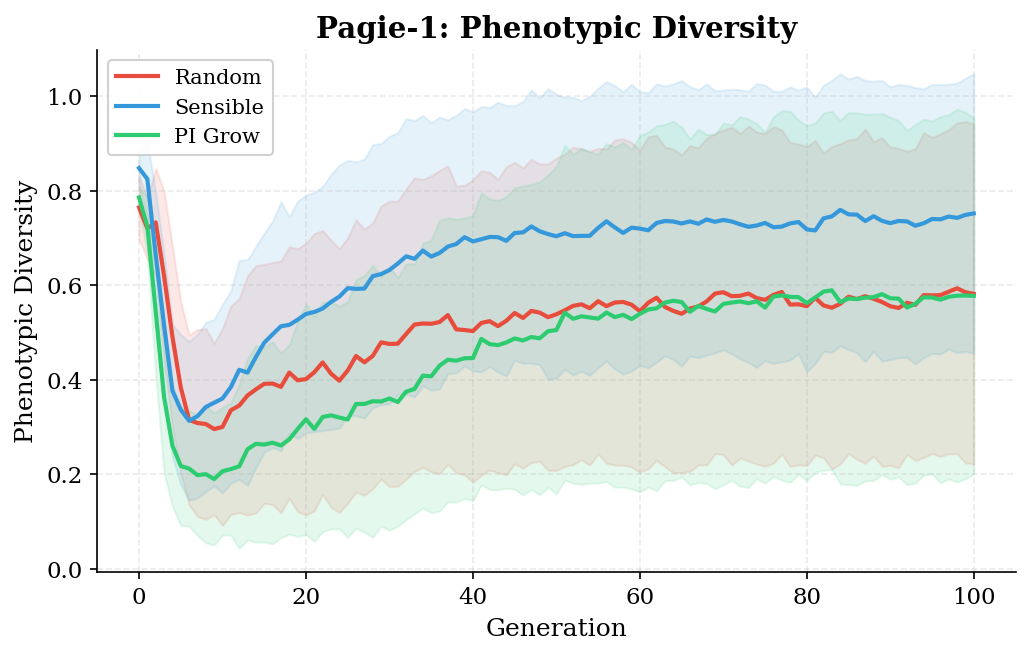

  Saved: fig3_phenodiv_pagie1.png


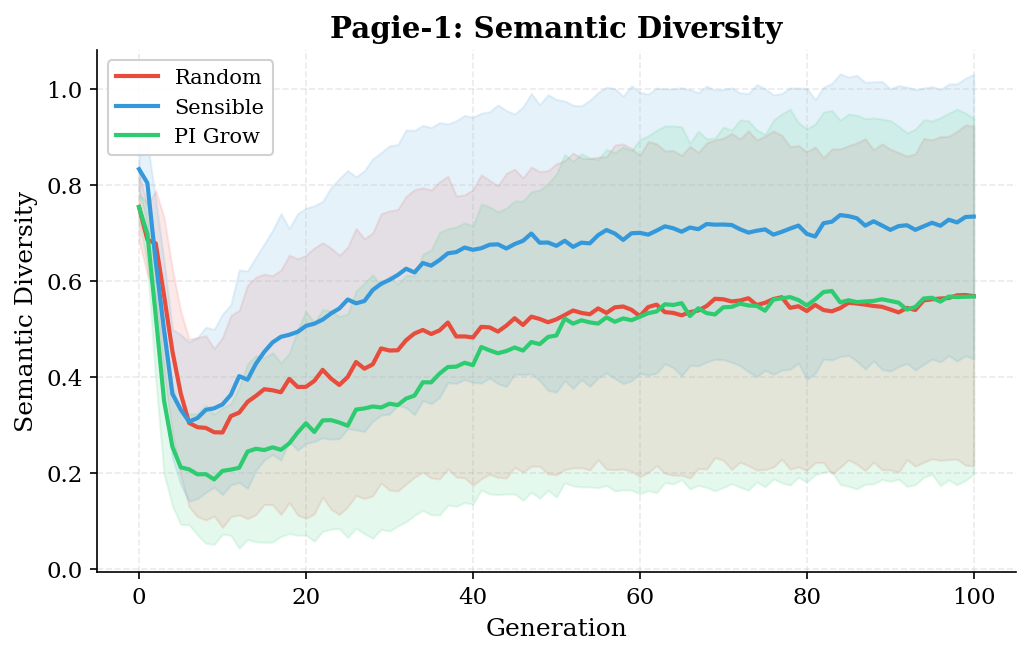

  Saved: fig3b_semdiv_pagie1.png


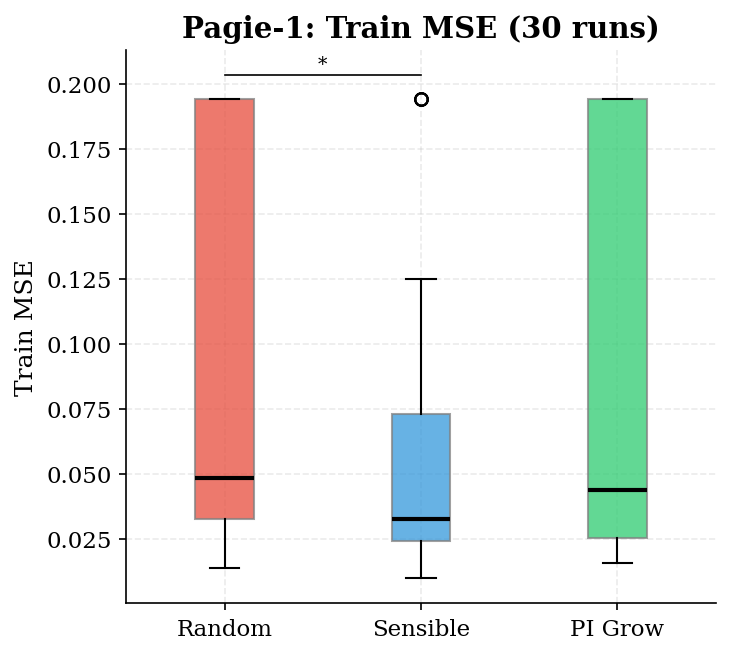

  Saved: fig4_train_pagie1.png


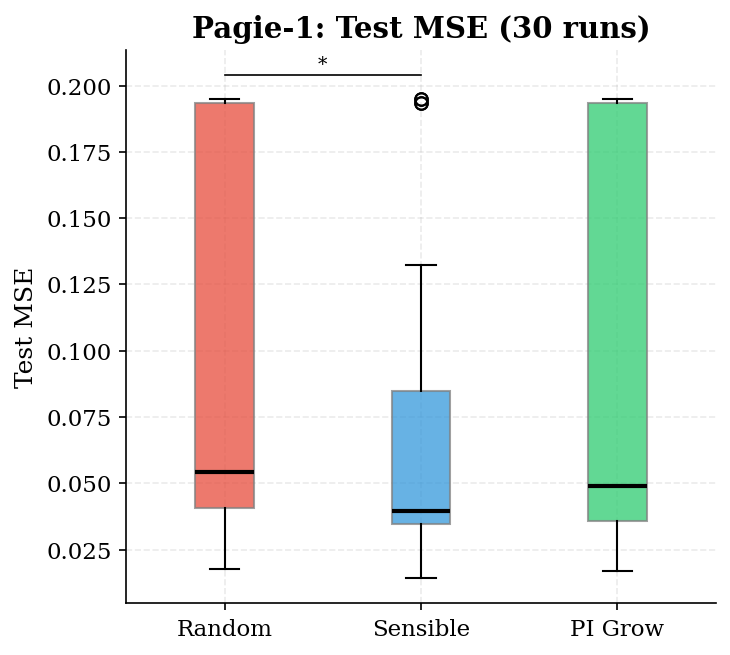

  Saved: fig5_test_pagie1.png


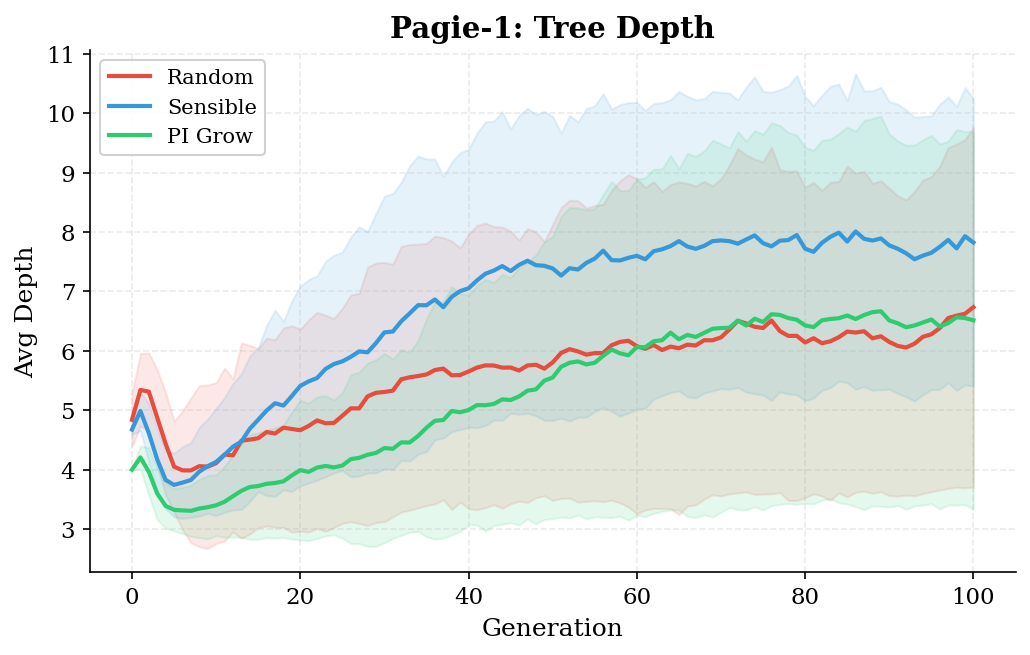

  Saved: fig6_depth_pagie1.png


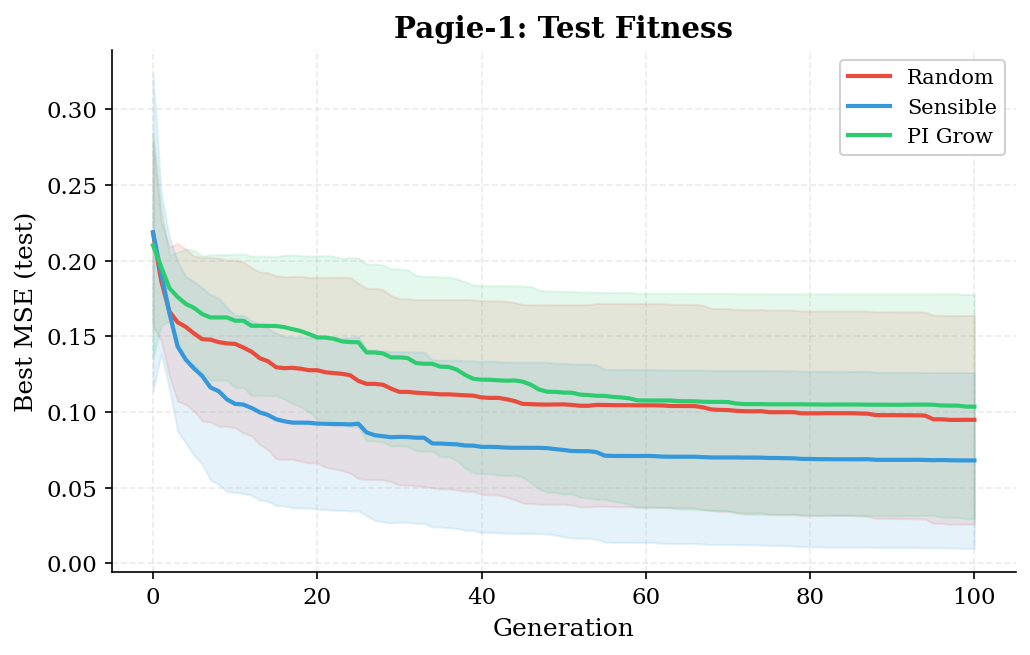

  Saved: fig7_testconv_pagie1.png

──────────────────────────────────────────────────
 Plots: Diabetes (Classification)
──────────────────────────────────────────────────


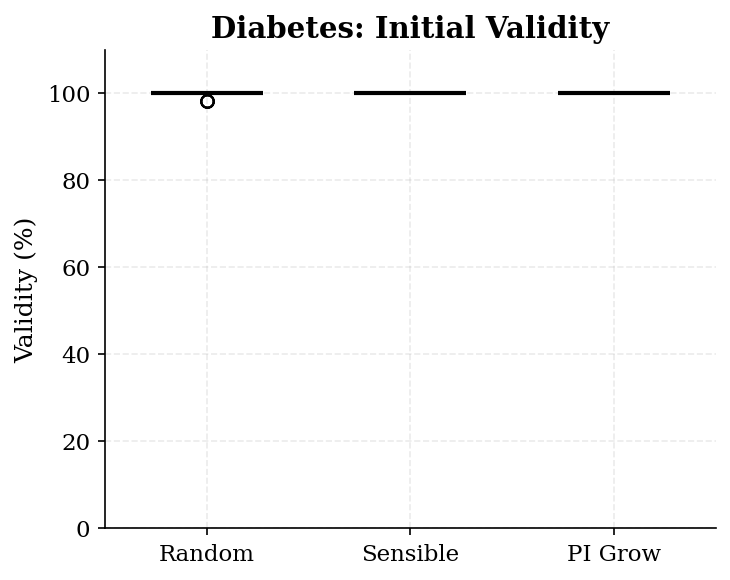

  Saved: fig1_diabetes_validity.png


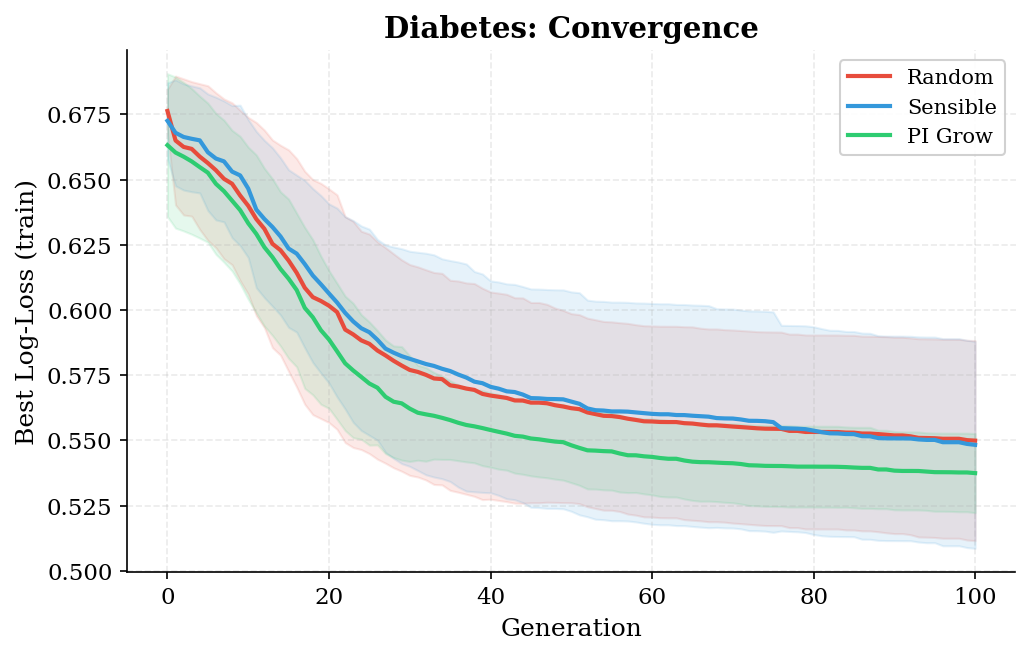

  Saved: fig2_conv_diabetes.png


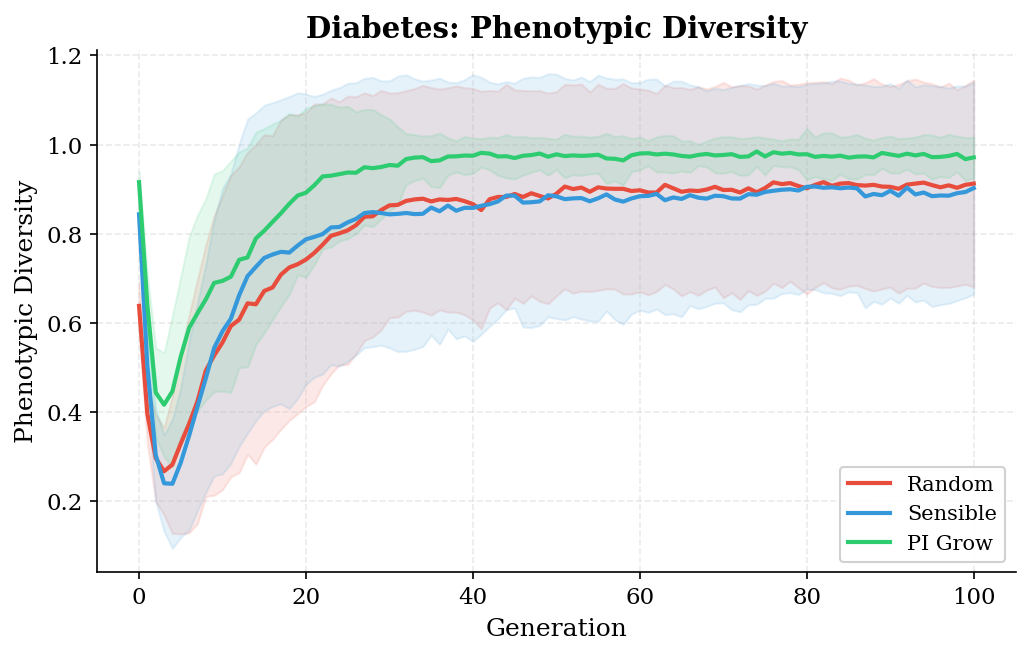

  Saved: fig3_phenodiv_diabetes.png


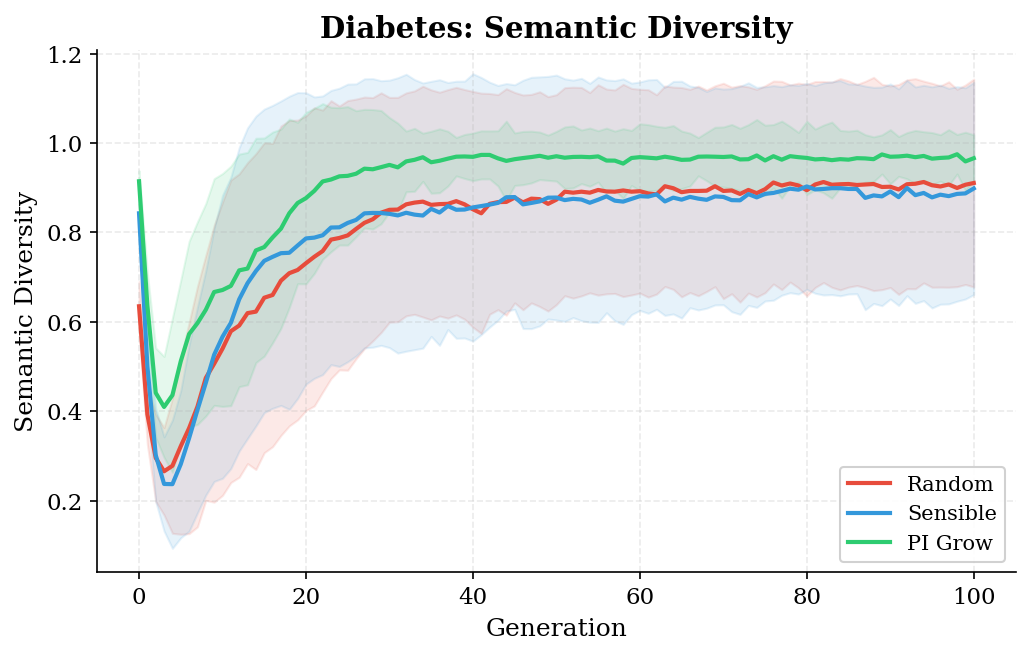

  Saved: fig3b_semdiv_diabetes.png


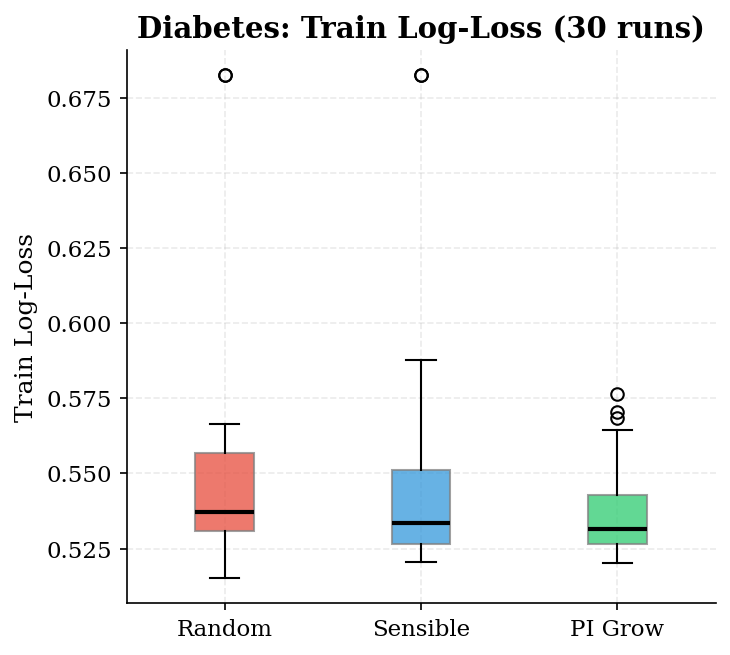

  Saved: fig4_train_diabetes.png


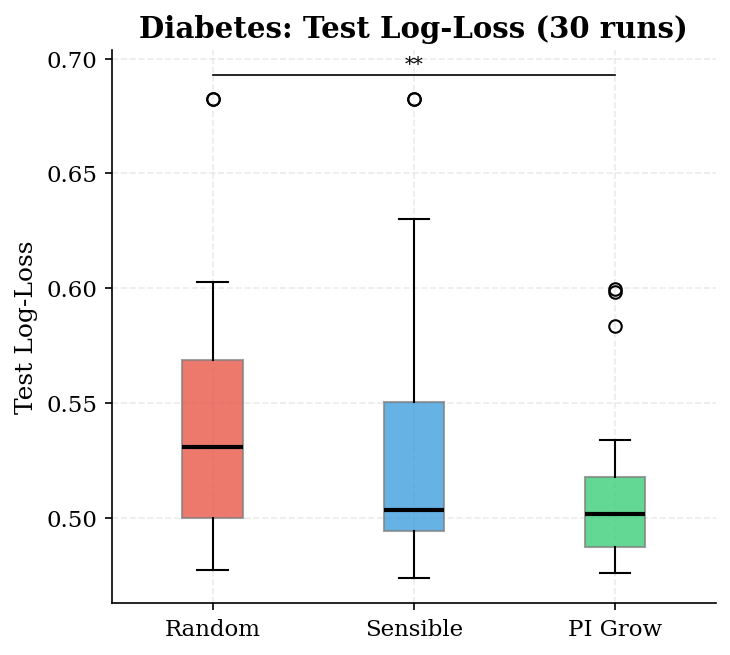

  Saved: fig5_test_diabetes.png


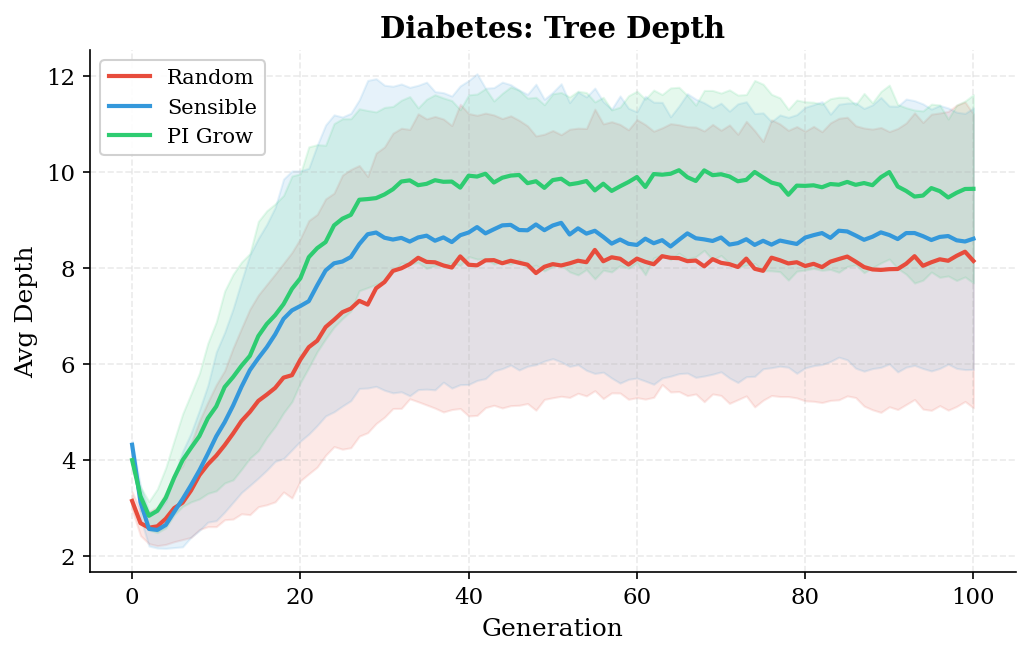

  Saved: fig6_depth_diabetes.png


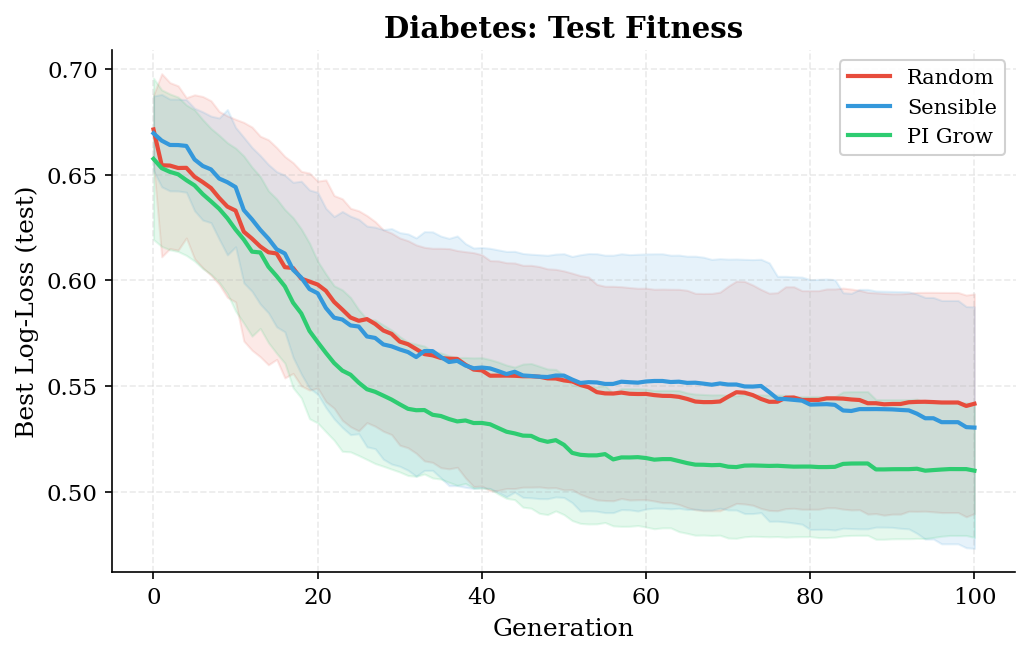

  Saved: fig7_testconv_diabetes.png


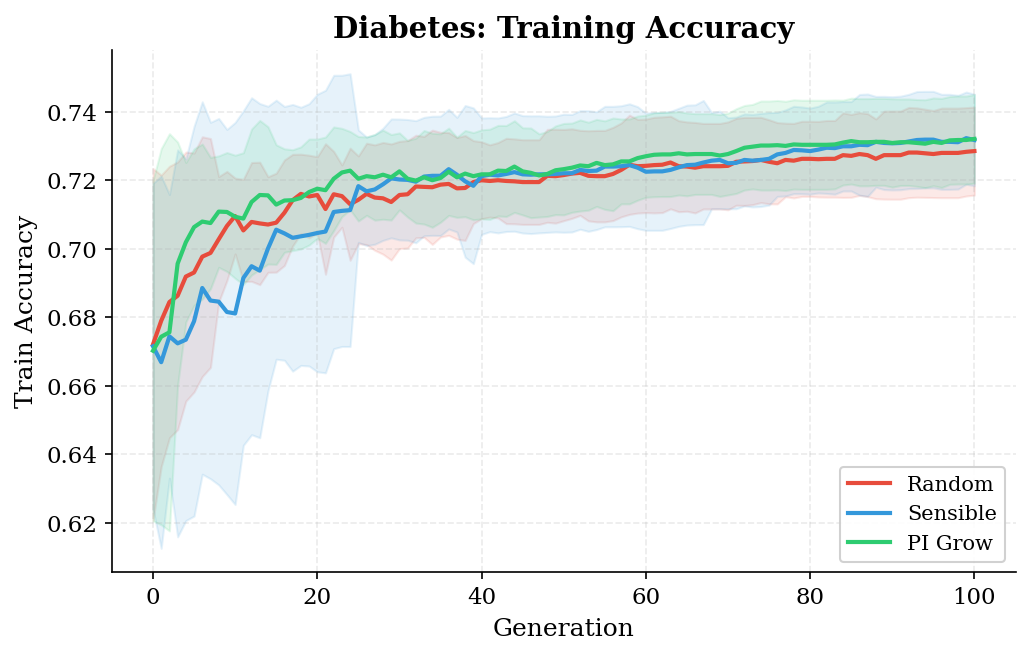

  Saved: fig8_trainacc_diabetes.png


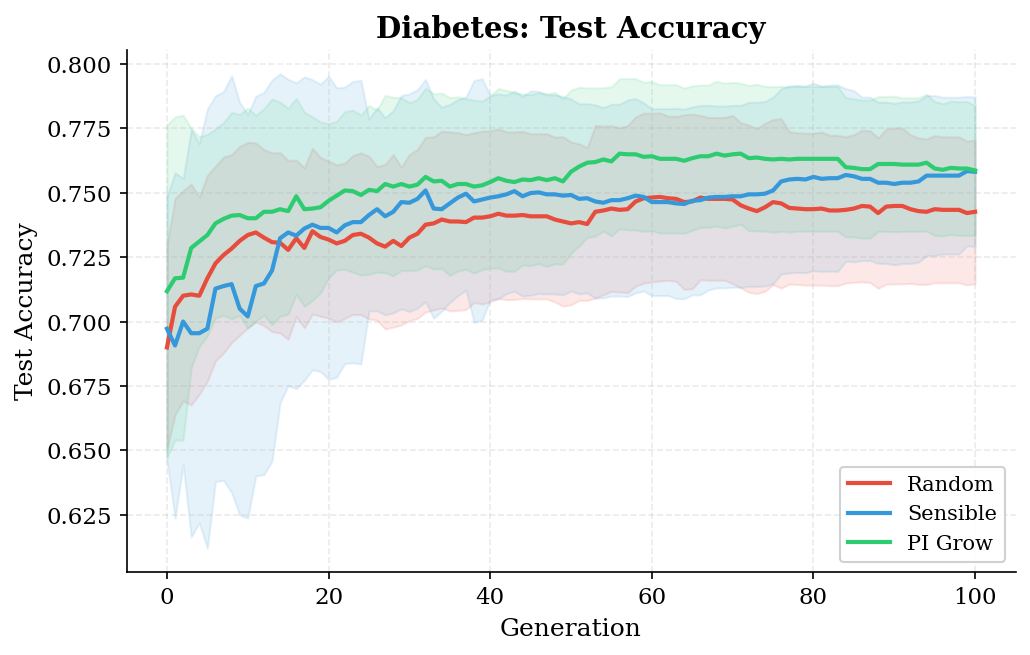

  Saved: fig9_testacc_diabetes.png


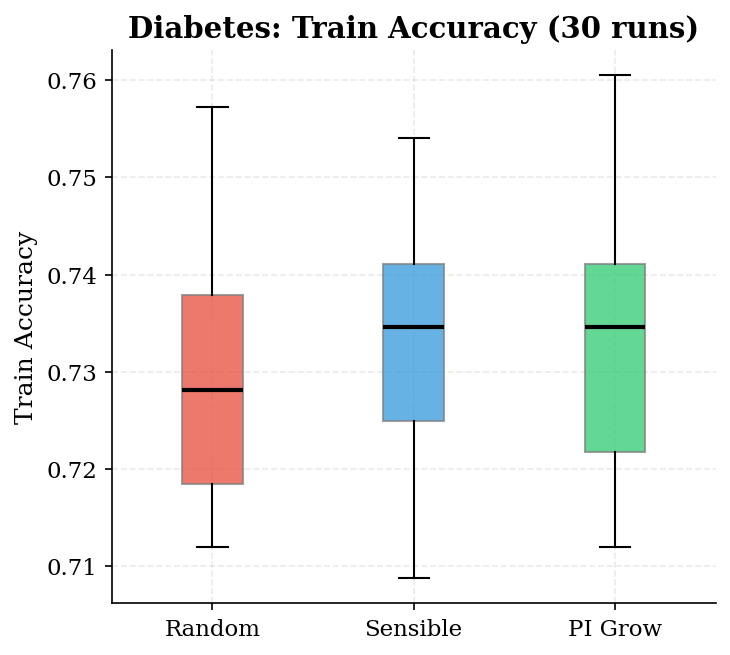

  Saved: fig10_trainacc_box_diabetes.png


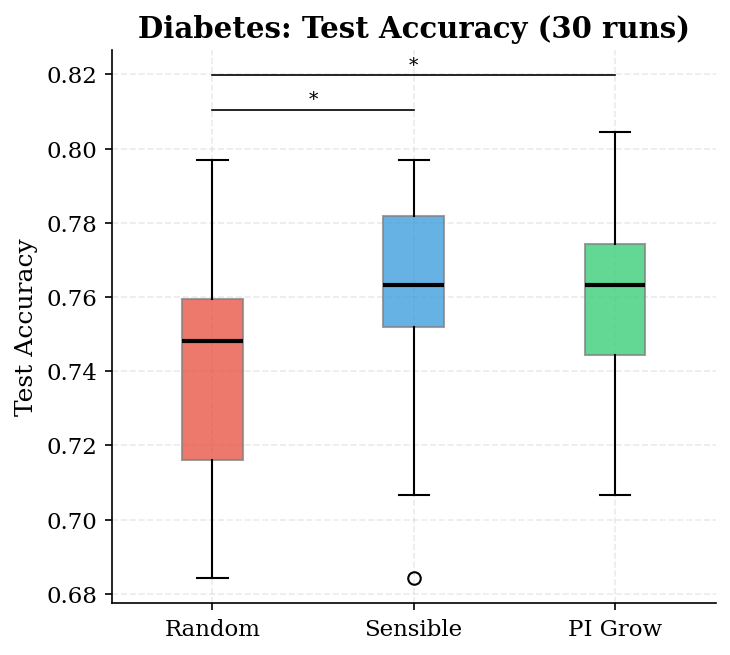

  Saved: fig11_testacc_box_diabetes.png


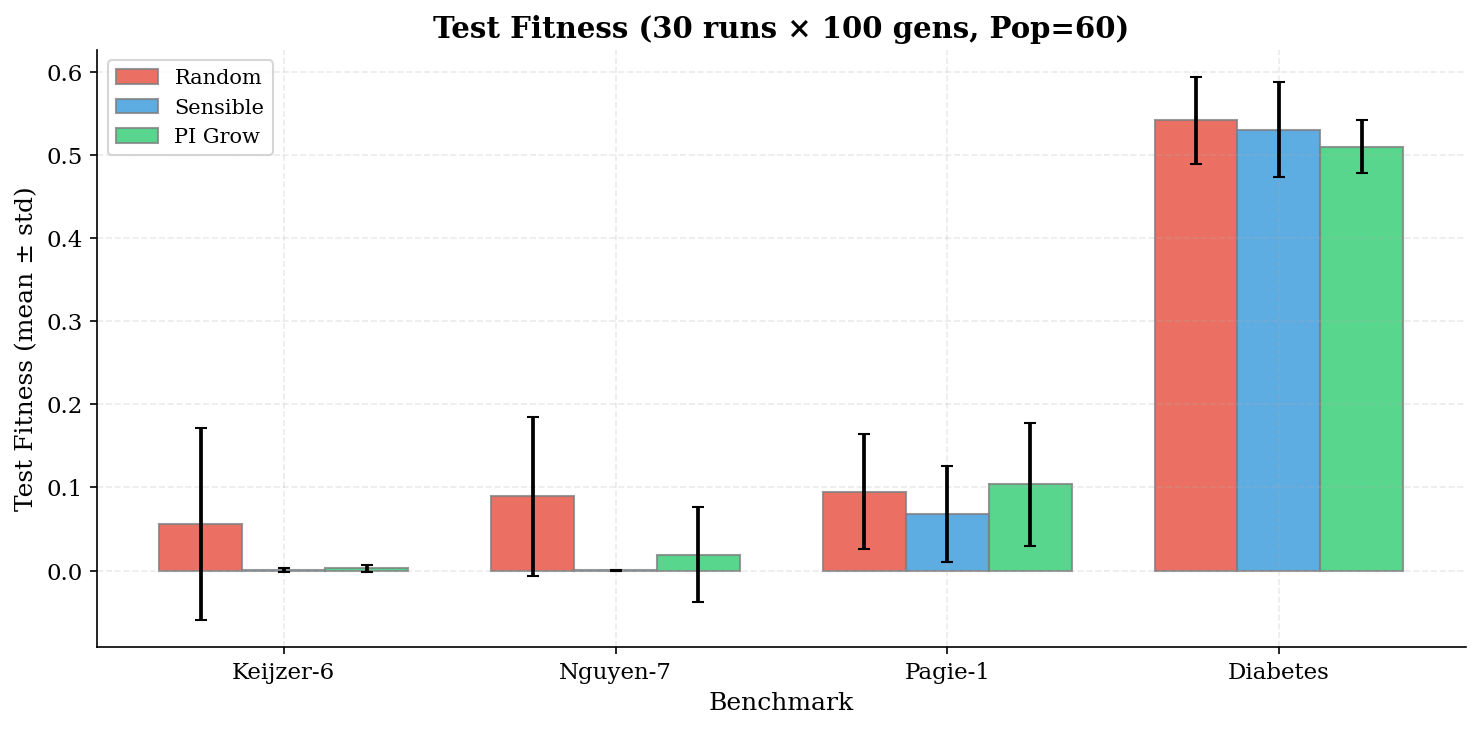

Saved: fig_summary_fitness.png


In [13]:
# ══════════════════════════════════════════════════════════════════════
plt.rcParams.update({
    'font.size': 11, 'font.family': 'serif',
    'axes.titlesize': 14, 'axes.titleweight': 'bold',
    'axes.labelsize': 12, 'legend.fontsize': 10,
    'figure.dpi': 150, 'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.grid': True, 'grid.alpha': 0.25, 'grid.linestyle': '--',
    'lines.linewidth': 1.8,
    'axes.spines.top': False, 'axes.spines.right': False,
})

def _box(pn, res, mf, yl, title, fp):
    """Box plot with significance brackets."""
    fig, ax = plt.subplots(figsize=(5, 4.5))
    d = {m: safe_vals([mf(r) for r in res[m]]) for m in METHODS}
    data = [d[m] for m in METHODS if d[m]]
    labels = [m for m in METHODS if d[m]]
    if data:
        bp = ax.boxplot(data, labels=labels, patch_artist=True,
                        medianprops=dict(color='black', linewidth=2))
        for patch, m in zip(bp['boxes'], labels):
            patch.set_facecolor(COLORS[m]); patch.set_alpha(0.75)
            patch.set_edgecolor('grey')
        ym = ax.get_ylim()[1]; yo = 0
        for i1, i2 in [(0,1),(0,2),(1,2)]:
            if i1 < len(labels) and i2 < len(labels) and d[labels[i1]] and d[labels[i2]]:
                _, p = mannwhitneyu(d[labels[i1]], d[labels[i2]])
                ss = sig_stars(p)
                if ss != 'ns':
                    yr = ym - ax.get_ylim()[0]
                    yp = ym + yo * yr * 0.07
                    ax.plot([i1+1, i2+1], [yp, yp], 'k-', lw=0.8)
                    ax.text((i1+i2+2)/2, yp+yr*0.01, ss, ha='center', fontsize=9)
                    yo += 1
    ax.set_ylabel(yl); ax.set_title(f'{pn}: {title}')
    plt.tight_layout()
    fn = f'{fp}_{pn.lower().replace("-","")}.png'
    plt.savefig(fn); plt.show()
    print(f"  Saved: {fn}")

def _line(pn, res, hk, yl, title, fp, clip_val=None):
    """Line plot with confidence band (mean ± std)."""
    fig, ax = plt.subplots(figsize=(7, 4.5))
    ng = len(res[METHODS[0]][0]['hist'][hk])
    xa = np.arange(ng)
    for m in METHODS:
        c = np.array([r['hist'][hk] for r in res[m]], dtype=float)
        if clip_val is not None:
            c = np.where(np.isnan(c) | (np.abs(c) > clip_val), np.nan, c)
        mn = np.nanmean(c, 0)
        sd = np.nanstd(c, 0)
        ax.plot(xa, mn, label=m, color=COLORS[m], linewidth=2)
        ax.fill_between(xa, mn - sd, mn + sd, color=COLORS[m], alpha=0.12)
    ax.set_xlabel('Generation'); ax.set_ylabel(yl)
    ax.set_title(f'{pn}: {title}')
    ax.legend(frameon=True, fancybox=True, framealpha=0.9)
    plt.tight_layout()
    fn = f'{fp}_{pn.lower().replace("-","")}.png'
    plt.savefig(fn); plt.show()
    print(f"  Saved: {fn}")

# ── Generate all plots ───────────────────────────────────────────────
for pn, res in all_results.items():
    task = PROBLEMS[pn]['task']
    print(f"\n{'─'*50}\n Plots: {pn} ({'Classification' if task=='classification' else 'Regression'})\n{'─'*50}")

    # 1. Initial Validity
    fig, ax = plt.subplots(figsize=(5, 4))
    d = {m: safe_vals([r['init']['validity']*100 for r in res[m]]) for m in METHODS}
    data = [d[m] for m in METHODS if d[m]]
    labels = [m for m in METHODS if d[m]]
    if data:
        bp = ax.boxplot(data, positions=list(range(1, len(data)+1)),
                        widths=0.55, patch_artist=True,
                        medianprops=dict(color='black', linewidth=2))
        for patch, m in zip(bp['boxes'], labels):
            patch.set_facecolor(COLORS[m]); patch.set_alpha(0.75)
            patch.set_edgecolor('grey')
    ax.set_xticks(list(range(1, len(labels)+1)))
    ax.set_xticklabels(labels)
    ax.set_ylabel('Validity (%)')
    ax.set_title(f'{pn}: Initial Validity')
    ax.set_ylim([0, max(110, ax.get_ylim()[1] + 5)])
    plt.tight_layout()
    fn = f'fig1_{pn.lower().replace("-","")}_validity.png'
    plt.savefig(fn); plt.show(); print(f"  Saved: {fn}")

    # 2. Convergence (train fitness)
    fl = 'Best Log-Loss (train)' if task == 'classification' else 'Best MSE (train)'
    _line(pn, res, 'min', fl, 'Convergence', 'fig2_conv', clip_val=1e6)

    # 3. Phenotypic Diversity (unique expressions)
    _line(pn, res, 'pheno_div', 'Phenotypic Diversity', 'Phenotypic Diversity', 'fig3_phenodiv')

    # 3b. Semantic Diversity (unique output behaviours)
    _line(pn, res, 'semantic_div', 'Semantic Diversity', 'Semantic Diversity', 'fig3b_semdiv')

    # 4. Train fitness box plot
    if task == 'classification':
        _box(pn, res, lambda r: r['train_fitness'], 'Train Log-Loss',
             f'Train Log-Loss ({N_RUNS} runs)', 'fig4_train')
    else:
        _box(pn, res, lambda r: r['train_fitness'], 'Train MSE',
             f'Train MSE ({N_RUNS} runs)', 'fig4_train')

    # 5. Test fitness box plot
    if task == 'classification':
        _box(pn, res, lambda r: r['test_fitness'], 'Test Log-Loss',
             f'Test Log-Loss ({N_RUNS} runs)', 'fig5_test')
    else:
        _box(pn, res, lambda r: r['test_fitness'], 'Test MSE',
             f'Test MSE ({N_RUNS} runs)', 'fig5_test')

    # 6. Tree Depth
    _line(pn, res, 'avg_depth', 'Avg Depth', 'Tree Depth', 'fig6_depth')

    # 7. Test Fitness convergence
    tfl = 'Best Log-Loss (test)' if task == 'classification' else 'Best MSE (test)'
    _line(pn, res, 'fitness_test', tfl, 'Test Fitness', 'fig7_testconv', clip_val=1e6)

    # Classification-specific
    if task == 'classification':
        _line(pn, res, 'train_acc', 'Train Accuracy', 'Training Accuracy', 'fig8_trainacc')
        _line(pn, res, 'test_acc',  'Test Accuracy',  'Test Accuracy',     'fig9_testacc')
        _box(pn, res, lambda r: r.get('train_acc', np.nan), 'Train Accuracy',
             f'Train Accuracy ({N_RUNS} runs)', 'fig10_trainacc_box')
        _box(pn, res, lambda r: r.get('test_acc', np.nan), 'Test Accuracy',
             f'Test Accuracy ({N_RUNS} runs)', 'fig11_testacc_box')

# ── Summary bar chart ────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(PROBLEMS)); w = 0.25
for i, m in enumerate(METHODS):
    mn_vals = []; sd_vals = []
    for pn in pnames:
        v = safe_vals([r['test_fitness'] for r in all_results[pn][m]])
        mn_vals.append(np.mean(v) if v else 0)
        sd_vals.append(np.std(v) if v else 0)
    ax.bar(x + i*w, mn_vals, w, yerr=sd_vals, label=m,
           color=COLORS[m], alpha=0.8, edgecolor='grey', capsize=3)
ax.set_xlabel('Benchmark')
ax.set_ylabel('Test Fitness (mean ± std)')
ax.set_title(f'Test Fitness ({N_RUNS} runs × {MAX_GENS} gens, Pop={POP_SIZE})')
ax.set_xticks(x + w); ax.set_xticklabels(pnames)
ax.legend(frameon=True); plt.tight_layout()
plt.savefig('fig_summary_fitness.png'); plt.show()
print("Saved: fig_summary_fitness.png")


In [ ]:
# ══════════════════════════════════════════════════════════════════════
# SAVE RESULTS

In [14]:
# ══════════════════════════════════════════════════════════════════════
def ser(o):
    if isinstance(o, (np.integer,)): return int(o)
    if isinstance(o, (np.floating, float)):
        return None if (np.isnan(o) if isinstance(o, float) else np.isnan(float(o))) else float(o)
    if isinstance(o, np.ndarray): return o.tolist()
    if isinstance(o, dict): return {k: ser(v) for k, v in o.items()}
    if isinstance(o, list): return [ser(v) for v in o]
    return o

with open('ge_results_v3.json', 'w') as f:
    json.dump(ser(all_results), f)

config = {
    'date': datetime.now().isoformat(),
    'version': 'v3_corrected',
    'grape': os.path.abspath(getattr(grape, '__file__', '?')),
    'fixes': [
        'FIX 1: CODON_CONSUMPTION=lazy (was eager) → Sensible/PI Grow now 100% valid',
        'FIX 2: Removed pexp from grammar → Keijzer-6 no longer trivially solved',
        'FIX 3: Random 100% on Diabetes is expected (10 features = many terminals)',
    ],
    'params': {
        'pop': POP_SIZE, 'gens': MAX_GENS, 'cx': P_CX, 'mut': P_MUT,
        'tourn': TOURN, 'elite': ELITE_SIZE,
        'max_tree_depth': MAX_TREE_DEPTH, 'codon': CODON_SIZE,
        'mapper': CODON_CONSUMPTION,
        'init_depth': [MIN_INIT_DEPTH, MAX_INIT_DEPTH],
        'init_gl': [MIN_INIT_GL, MAX_INIT_GL],
    },
    'grammar': '{+, -, *, pdiv, sin, tanh, plog, psqrt} + ephemeral constants',
    'methods': METHODS, 'runs': N_RUNS, 'seed': SEED, 'seconds': total_t,
    'problems': {pn: {'desc': pi['desc'], 'task': pi['task']}
                 for pn, pi in PROBLEMS.items()},
}
with open('experiment_config_v3.json', 'w') as f:
    json.dump(config, f, indent=2)

print(f"\n{'='*72}")
print(f" DONE — {total_t/60:.1f} min")
print(f" Parameters: Pop={POP_SIZE} Gens={MAX_GENS} Cx={P_CX} Mut={P_MUT} "
      f"Tourn={TOURN} Elite={ELITE_SIZE}")
print(f" Mapper: {CODON_CONSUMPTION} | MaxDepth: {MAX_TREE_DEPTH}")
print(f"{'='*72}")



 DONE — 22.5 min
 Parameters: Pop=60 Gens=100 Cx=0.9 Mut=0.05 Tourn=3 Elite=1
 Mapper: lazy | MaxDepth: 17
